<a id="navigation"></a>

## Navigation
* **[Model Building](#model-building)**: Details about and Insights into the five models I'd used
* **[Sentiment Score](#sentiment-score)**: Construction of three types of Sentiment Score
* **[Analytical Results](#analytical-results)**: Graphs and Plots on the US Presidential Election in 2016

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

In [2]:
import os
import re
from datetime import datetime
from pprint import pprint
import spacy
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
import pickle
os.chdir('/home3/r09725056/Desktop/analysis-ChingYaoL')
print(os.getcwd())
# Use relative paths in the code

/home3/r09725056/Desktop/analysis-ChingYaoL


In [3]:
for file in os.listdir():
    print(file, end=' ')

input code output temp .git README.md README_about_USFB_Data.pdf 

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 讓 DataFrame Output可以重複疊起來
pd.set_option('display.max_columns', None) # show all columns

In [5]:
import string
import fasttext
import contractions # resolving contractions and slangs, e.g. "yall're happy now" --> "you all are happy now"
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [6]:
import nltk
# nltk.download('stopwords');
import demoji
# demoji.download_codes()

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import pipeline

In [12]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

In [13]:
# def sentiment_score_BERT(message):
#     encoded_input = tokenizer.encode(message, return_tensors='pt')
#     output = model(encoded_input)
#     return output.logits

<a id="model-building"></a>

# Model Building
[[Back to Navigation]](#navigation)

* Know Your Model
    * A Quick Look at the Models
* [Model-Mining](#model-mining)
    * Model-Mining: [Keyword Sanity Checks](#keyword-sanity-checks)
    * Model-Mining: [Score Distributions](#score-distribution)
        * Score Distributions - [Graphical Method](#graphical-method)
        * Score Distributions - [Mathematical Method](#mathematical-method) (Wasserstein Distance)

# A Quick look at the models
There are five models to be used.
* distilBERT
* RoBERTa-large
* RoBERTa-tweet
* BERT-star
* BERT-emotion

More info about the models in USFB_full_presentation.pdf

#### Download all five pretained (and finetuned) models

In [14]:
distilBERT = pipeline('sentiment-analysis') # distilbert-base-uncased-finetuned-sst-2-english
RoBERTa_large = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")
BERT_star = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment", return_all_scores=True)
BERT_emotion = pipeline("sentiment-analysis", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)
# RoBERTa_tweet = pipeline("sentiment-analysis", model='cardiffnlp/twitter-roberta-base-sentiment') # No max_length set
                                                                                                    # Need to set it manually

#### This block is from the samlpe code of RoBERTa-tweet, which is (partly) needed for presetting.

In [15]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request

task='sentiment'
model_name = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set up the labels
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PyTorch
tweet_model = AutoModelForSequenceClassification.from_pretrained(model_name)

text = "Good night 😊"
encoded_input = tokenizer(text, truncation=True, max_length=512, return_tensors='pt') # encoded_input: {'input_ids': tensor(...), 'attention_mask': tensor(...)}
output = tweet_model(**encoded_input)        # output: SequenceClassifierOutput(loss, logits, ...)
scores = output[0][0].detach().numpy() # output[0]: 2-dim logits -> tensor([[...]], grad_fn=<AddmmBackward>)
                                       # output[0][0]: 1-dim logits -> tensor([...], grad_fn=<SelectBackward>)
                                       # output[0][0].detach(): 1-dim logits(tensor) -> tensor([...])
scores = softmax(scores)      # shove the tensor through a softmax function

# Print the (readable) result in descending order
ranking = np.argsort(scores)  # get the rankings for each position in the array
ranking = ranking[::-1]       # reverse the order
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

# 1) positive 0.8466
# 2) neutral 0.1458
# 3) negative 0.0076

1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


In [16]:
labels

['negative', 'neutral', 'positive']

#### Setting for RoBERTa-tweet

In [17]:
# The interface (usage) is designed to be indistinguishable from the others.
def RoBERTa_tweet(text, truncation=True):
    global tweet_model
    encoded_input = tokenizer(text, truncation=truncation, max_length=512, return_tensors='pt')
    output = tweet_model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    max_pos = np.argmax(scores) # Get position for the highest score
    labels = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    
    return [{'label': labels[max_pos], 'score': scores[max_pos]}]

<a id="model-mining"></a>

# Model-Mining
The results are shown in the USFB_full_presentation.pdf

In [18]:
def sentiment_score(message):
    print(message)
    print()
    
    distilBERT_result = distilBERT(message)[0]
    RoBERTa_large_result = RoBERTa_large(message)[0]
    RoBERTa_tweet_result = RoBERTa_tweet(message)[0] # Notice the RoBERTa-tweet interface is indistinguishable from the others
    BERT_emotion_result = BERT_emotion(message)[0]
    BERT_star_result = BERT_star(message)[0]
    
    BERT_star_result = sorted(BERT_star_result, key=lambda k: k['score'], reverse=True) # sort by score
    
    print('   distilBERT: {label}: {score}'.format(**distilBERT_result))
    print('RoBERTa-large: {label}: {score}'.format(**RoBERTa_large_result))
    print('RoBERTa-tweet:  {label}: {score}'.format(**RoBERTa_tweet_result))
    print()
    print('    BERT_star:  {label:>7}: {score}'.format(**BERT_star_result[0]))
    print('                {label:>7}: {score}'.format(**BERT_star_result[1]))
    print()
    print(' BERT_emotion:')
    for emotion_result in BERT_emotion_result:
        print(f"{emotion_result['label']:>23}: {emotion_result['score']}")

In [19]:
# sentiment_score("It should have been better.")

In [20]:
# sentiment_score('I love his charisma but I hate his policies.')

In [21]:
# sentiment_score('I hate his policies but I love his charisma.')

In [22]:
# sentiment_score('I am happy that you are angry.')

In [23]:
# sentiment_score('I am angry that you are happy.')

In [24]:
# sentiment_score('I love his charisma. I hate his policies.')

In [25]:
# sentiment_score('I hate his policies. I love his charisma.')

In [27]:
# sentiment_score('SO HOW can people even wear fur, knowing it comes from creatures like these.  <3 :(')

<a id="keyword-sanity-checks"></a>

# Model-Mining :  &emsp; Keyword Sanity Checks
There is no perfect model. We have to make sure that there isn't any serious systematic bias so that we can get reliable sentiment predictions.<br>
Keywords in this case must (1) be of our research interest and (2) be frequent enough that it matters.<br><br>
The results are shown in USFB_full_presentation.pdf

In [36]:
# sentiment_score('trump')

In [37]:
# sentiment_score('Hillary')

In [38]:
# sentiment_score('Donald Trump')

In [39]:
# sentiment_score('Hillary Clinton')

In [40]:
# sentiment_score('Republican Party')

In [41]:
# sentiment_score('Democratic Party')

In [42]:
# sentiment_score('Republicans')

In [43]:
# sentiment_score('Democrats')

In [44]:
# sum(comment['comment_message'].str.lower().str.contains('trump'))
# sum(comment['comment_message'].str.lower().str.contains('hillary'))
# sum(comment['comment_message'].str.lower().str.contains('donald trump'))
# sum(comment['comment_message'].str.lower().str.contains('hillary clinton'))
# sum(comment['comment_message'].str.lower().str.contains('republican party'))
# sum(comment['comment_message'].str.lower().str.contains('democratic party'))
# sum(comment['comment_message'].str.lower().str.contains(r'republicans?'))
# sum(comment['comment_message'].str.lower().str.contains(r'democrats?'))

In [45]:
# sentiment_score('Donald')

In [46]:
# sentiment_score('donald')

In [556]:
# sentiment_score('Vote For Trump')

In [555]:
# sentiment_score('VoteForTrump')

In [553]:
# sentiment_score('#gohillary')

In [554]:
# sentiment_score('#gotrump')

In [551]:
# sentiment_score('We will vote for you! #gotrump')

In [552]:
# sentiment_score('We will vote for you! #gohillary')

In [47]:
# qt99 = comment['comment_message'].str.len().quantile(0.99) # 727.0

In [48]:
# sns.histplot(comment.loc[comment['comment_message'].str.len() <= qt99, 'comment_message']) # qt99 = 727.0

<a id="score-distribution"></a>

#  Model-Mining :   &ensp; Score Distribution
Each model might have its preference/pattern for assigning scores, e.g. more toward the ends or more uniformly distributed.<br>
However, for the same data, there should only be one single correct answer (though unknown).<br>
Therefore, score distribution shouldn't vary too much across models.

### First of all, we have to [apply the models](#apply-models) and save the results to the DataFrame
In order to do this, we have to test for each model <u>which way of applying them works best (faster)</u>?

### Test for speed: Which ways of applying models are best?
Each model has two options
1. **model(list(Series))**: feed the Series into the model as a whole
2. **Series.apply(model)**: feed one comment into the model at a time, and repeat it across the entire Series

In [49]:
# Toy Data (10000 samples)
# comment_sm = comment.sample(10000).copy()

#### distilBERT

In [50]:
# %%time
# distilBERT(list(comment_sm['comment_message']), truncation=True);
# CPU times: user 25min 27s, sys: 10min 59s, total: 36min 27s  # 100 sample
# Wall time: 2min 6s

In [51]:
# %%time
# comment_sm['comment_message'].apply(lambda x: distilBERT(x, truncation=True));
# CPU times: user 6min 26s, sys: 20 s, total: 6min 46s # 100 sample
# Wall time: 20.2 s
# CPU times: user 11min 42s, sys: 1min 4s, total: 12min 46s    # 1000 sample
# Wall time: 1min 18s

#### RoBERTa-large

In [52]:
# %%time
# RoBERTa_large(list(comment_sm['comment_message']), truncation=True);
# CPU times: user 2h 12min 27s, sys: 49min 33s, total: 3h 2min 1s
# Wall time: 18min 57s

In [53]:
# %%time
# comment_sm['comment_message'].apply(lambda x: RoBERTa_large(x, truncation=True));
# CPU times: user 2h 10min 47s, sys: 11min 2s, total: 2h 21min 49s
# Wall time: 12min 44s

#### RoBERTa-tweet

In [54]:
# %%time
# tweet_model(np.array(comment_sm['comment_message']));

In [55]:
# %%time
# comment_sm['comment_message'].apply(lambda x: RoBERTa_tweet(x, truncation=True));
# CPU times: user 19min 1s, sys: 58.2 s, total: 19min 59s
# Wall time: 54.2 s

#### BERT-star

In [56]:
# %%time
# BERT_star(list(comment_sm['comment_message']), truncation=True);
# CPU times: user 46min 3s, sys: 24min 47s, total: 1h 10min 51s
# Wall time: 3min 56s

In [57]:
# %%time
# comment_sm['comment_message'].apply(lambda x: BERT_star(x, truncation=True));
# CPU times: user 18min 52s, sys: 1min 15s, total: 20min 7s
# Wall time: 1min 15s

#### BERT-emotion

In [58]:
# %%time
# BERT_emotion(list(comment_sm['comment_message']), truncation=True);
# CPU times: user 45min 38s, sys: 23min 57s, total: 1h 9min 35s
# Wall time: 4min 8s

In [59]:
# %%time
# comment_sm['comment_message'].apply(lambda x: BERT_emotion(x, truncation=True));
# CPU times: user 14min 5s, sys: 45 s, total: 14min 50s
# Wall time: 39.8 s

<a id="apply-models"></a>

### According to the speed tests, we can design the best way to apply each model.
According to the above experiment, we can now conclude that all five models are applied most efficiently using the **Series.apply(model)** method. In my opinion, feeding an entire list into a model might force the system to juggle with too many resources at the same time, and therefore isn't as efficient as dealing one thing at a time and repeating the simple process across the list.

In [60]:
# Define functions to extract sentiment-related features (using the models)
def extract_result(model, message):
    "Used to extract results from distilBERT, RoBERTa-large, and RoBERTa-tweet"
    result = model(message, truncation=True)[0]
    return result['label'], result['score']

def extract_BERT_star_result(message):
    "Used to extract results from BERT-star"
    BERT_star_result = BERT_star(message, truncation=True)[0]
    weighted_stars = [int(d['label'][0]) * d['score'] for d in BERT_star_result]
    expected_score = sum(weighted_stars)
    
    BERT_star_result = sorted(BERT_star_result, key=lambda k: k['score'], reverse=True)[:2] # sort by score
    first = BERT_star_result[0]
    second = BERT_star_result[1]
    
    expected_top2score = int(first['label'][0]) * first['score'] + int(second['label'][0]) * second['score']
    expected_top2score /= (first['score'] + second['score'])
    
    return first['label'], first['score'], second['label'], second['score'], expected_score, expected_top2score

def extract_BERT_emotion_result(message):
    "Used to extract results from BERT-emotion"
    result = BERT_emotion(message, truncation=True)[0] # Get result from the BERT_emotion model
    lst = list(d['score'] for d in result)
    
    sorted_result = sorted(result, key=lambda k: k['score'])[-1]
    highest_label = sorted_result['label']
    highest_score = sorted_result['score']
    lst.append(highest_label)
    lst.append(highest_score)
    
    return lst

#### Apply the Models and Create Sentiment Features

### Read in the comment data

In [ ]:
# Read in the commment data
comment = pd.read_pickle(r'temp/comment/english_only/comment_0.pkl')
comment.head(2)

In [ ]:
######################################  distilBERT  ######################################
# Apply the model
result = comment['comment_message'].apply(lambda x: extract_result(distilBERT, x))
# Set the results back to DataFrame
comment[['distilBERT_label', 'distilBERT_prob']] = tuple(result)
# Create sentiment score(polarity)
comment['distilBERT_score'] = comment['distilBERT_prob'] * (comment['distilBERT_label'] == 'POSITIVE').apply(lambda x: 1 if x else -1)

####################################  RoBERTa-large  ######################################
# Apply the model
result = comment['comment_message'].apply(lambda x: extract_result(RoBERTa_large, x))
# Set the results back to DataFrame
comment[['RoBERTa_large_label', 'RoBERTa_large_prob']] = tuple(result)
# Create sentiment score(polarity)
comment['RoBERTa_large_score'] = comment['RoBERTa_large_prob'] * (comment['RoBERTa_large_label'] == 'POSITIVE').apply(lambda x: 1 if x else -1)

####################################  RoBERTa-tweet  ######################################
# Apply the model
result = comment['comment_message'].apply(lambda x: extract_result(RoBERTa_tweet, x))
# Set the results back to DataFrame
comment[['RoBERTa_tweet_label', 'RoBERTa_tweet_prob']] = tuple(result)

#######################################  BERT-star  #######################################
# Apply model and Save Results
star_cols = ['BERT_star_1stLabel', 'BERT_star_1stProb', 'BERT_star_2ndLabel', 'BERT_star_2ndProb', 'BERT_star_expectedScore', 'BERT_star_expectedTop2Score']
comment[star_cols] = tuple(comment['comment_message'].apply(extract_BERT_star_result))

#####################################  BERT-emotion  ######################################
# Apply model and Save Results
emot_cols = ['BERT_emotion_sadness', 'BERT_emotion_joy', 'BERT_emotion_love', 'BERT_emotion_anger', 'BERT_emotion_fear', 'BERT_emotion_surprise', 'BERT_emotion_highest', 'BERT_emotion_highestScore']
comment[emot_cols] = tuple(comment['comment_message'].apply(extract_BERT_emotion_result))
# Create self-defined score for BERT_emotion
# where POSITIVE = joy, love, surprise, NEGATIVE = sadness, anger, fear
comment['BERT_emotion_pos'] = comment['BERT_emotion_joy'] + comment['BERT_emotion_love'] + comment['BERT_emotion_surprise']
comment['BERT_emotion_neg'] = comment['BERT_emotion_sadness'] + comment['BERT_emotion_anger'] + comment['BERT_emotion_fear']
comment['BERT_emotion_score'] = comment['BERT_emotion_pos'] - comment['BERT_emotion_neg']

In [ ]:
# Save the sentiment features
comment.to_pickle(r'temp/comment/BERT_sentiment/comment_0.pkl')

In [8]:
# Read in the new data
comment = pd.read_pickle(r'temp/comment/BERT_sentiment/comment_0.pkl')

In [11]:
# comment.loc[comment['comment_message'].apply(len) > 512, 'comment_message'].apply(len).describe()

In [9]:
comment.shape

(2548470, 26)

In [10]:
comment.head(2)

,comment_message,post_id,comment_created_time,distilBERT_label,distilBERT_prob,distilBERT_score,RoBERTa_large_label,RoBERTa_large_prob,RoBERTa_large_score,RoBERTa_tweet_label,RoBERTa_tweet_prob,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedScore,BERT_emotion_sadness,BERT_emotion_joy,BERT_emotion_love,BERT_emotion_anger,BERT_emotion_fear,BERT_emotion_surprise,BERT_emotion_highest,BERT_emotion_highestScore,BERT_star_expectedTop2Score,RoBERTa_tweet_score
0,I've never liked the thought of Turkey. Even b...,198650096517_10154477788551518,2016-08-22 21:54:13+00:00,POSITIVE,0.990771,0.990771,NEGATIVE,0.998820,-0.998820,NEGATIVE,0.964068,2 stars,0.446742,1 star,0.368282,1.889820,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger,0.750804,1.548133,-0.964068
1,This is not acceptable. But we have let them g...,519305544814653_898285223583348,2015-03-30 23:02:28+00:00,NEGATIVE,0.998380,-0.998380,NEGATIVE,0.999445,-0.999445,NEGATIVE,0.926214,2 stars,0.423336,3 stars,0.314831,2.240447,0.028839,0.114509,0.003014,0.846426,0.005269,0.001943,anger,0.846426,2.426504,-0.926214


<a id="graphical-method"></a>

## Now, Back to Score Distribution
There are two ways to compare distributions.
* Graphical Method: Plot out the scores visually, and Construct the scores in a reasonable manner
* Mathematical Method: Wasserstein distance

## Score Distribution - Graphical Method

### DistilBERT

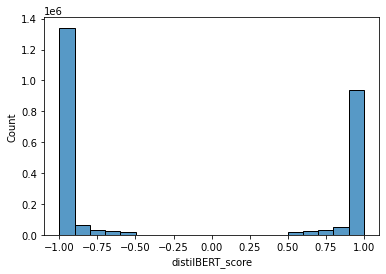

In [16]:
sns.histplot(comment['distilBERT_score'], bins=20);

### RoBERTa_large

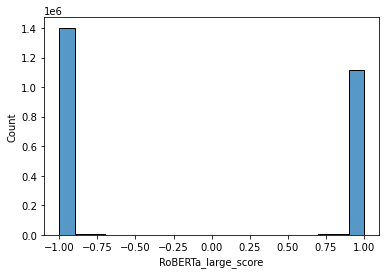

In [72]:
sns.histplot(data=comment, x='RoBERTa_large_score', bins=20);

### RoBERTa_tweet

In [42]:
comment.head(1)

,comment_message,post_id,comment_created_time,distilBERT_label,distilBERT_prob,distilBERT_score,RoBERTa_large_label,RoBERTa_large_prob,RoBERTa_large_score,RoBERTa_tweet_label,RoBERTa_tweet_prob,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedScore,BERT_emotion_sadness,BERT_emotion_joy,BERT_emotion_love,BERT_emotion_anger,BERT_emotion_fear,BERT_emotion_surprise,BERT_emotion_highest,BERT_emotion_highestScore,BERT_star_expectedTop2Score
0,I've never liked the thought of Turkey. Even b...,198650096517_10154477788551518,2016-08-22 21:54:13+00:00,POSITIVE,0.990771,0.990771,NEGATIVE,0.99882,-0.99882,NEGATIVE,0.964068,2 stars,0.446742,1 star,0.368282,1.88982,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger,0.750804,0.420589


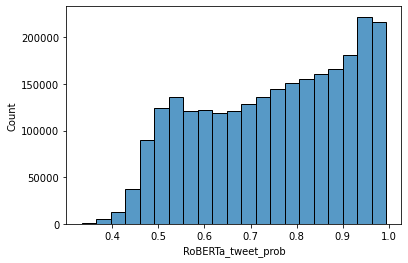

In [51]:
sns.histplot(data=comment, x='RoBERTa_tweet_prob', bins=21);

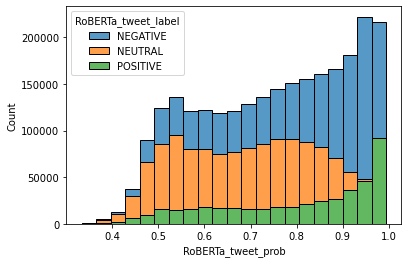

In [56]:
sns.histplot(data=comment, x='RoBERTa_tweet_prob', hue='RoBERTa_tweet_label', multiple="stack", bins=21, hue_order=['NEGATIVE', 'NEUTRAL', 'POSITIVE']);

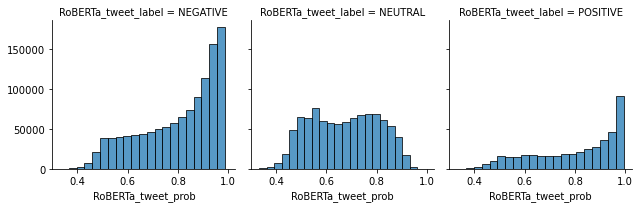

In [55]:
g = sns.FacetGrid(data=comment, col='RoBERTa_tweet_label', col_order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
g.map(sns.histplot, 'RoBERTa_tweet_prob', bins=21);

In [43]:
# Describe the probability where RoBERTa_tweet_label is NEUTRAL
comment.loc[comment['RoBERTa_tweet_label'] == 'NEUTRAL', 'RoBERTa_tweet_prob'].describe()

count    958123.000000
mean          0.671427
std           0.133552
min           0.333569
25%           0.552533
50%           0.675259
75%           0.784301
max           0.961910
Name: RoBERTa_tweet_prob, dtype: float64

In [96]:
# Get the median probability where RoBERTa_tweet_label is NEUTRAL
neutral_median = comment.loc[comment['RoBERTa_tweet_label'] == 'NEUTRAL', 'RoBERTa_tweet_prob'].median()

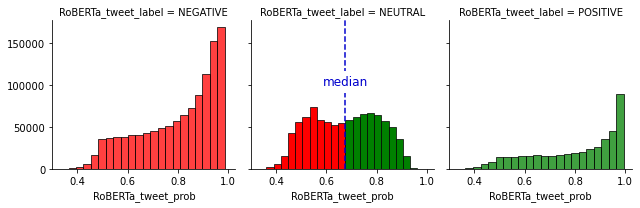

In [63]:
g = sns.FacetGrid(data=comment, col='RoBERTa_tweet_label', hue='RoBERTa_tweet_label', hue_kws={'color': ['red', 'gold', 'green']}, hue_order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'], col_order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
_ = g.map(sns.histplot, 'RoBERTa_tweet_prob', bins=22)
# Plot a vertical line for the median
_, ax2, _ = g.axes[0]
_ = ax2.axvline(neutral_median, ls='--', c='mediumblue');
# Add a text for the line
_ = ax2.text(neutral_median, 100000, "median", ha='center', c='mediumblue', size=12, backgroundcolor='w')
# Color the histogram in two colors
cutoff = (len(ax2.axes.patches) // 2) + 1
for patch in ax2.axes.patches[:cutoff]:
    patch.set_facecolor('red')
for patch in ax2.axes.patches[cutoff:]:
    patch.set_facecolor('green')

In [64]:
comment['RoBERTa_tweet_score'] = comment.apply(lambda row: -row['RoBERTa_tweet_prob'] \
                                  if (row['RoBERTa_tweet_label'] == 'NEGATIVE'\
                                      or (row['RoBERTa_tweet_label'] == 'NEUTRAL' and row['RoBERTa_tweet_prob'] < neutral_median))\
                                  else row['RoBERTa_tweet_prob'], axis=1)

In [66]:
# comment[['RoBERTa_tweet_label', 'RoBERTa_tweet_prob', 'RoBERTa_tweet_score']]

In [93]:
comment.head(2)

,comment_message,post_id,comment_created_time,distilBERT_label,distilBERT_prob,distilBERT_score,RoBERTa_large_label,RoBERTa_large_prob,RoBERTa_large_score,RoBERTa_tweet_label,RoBERTa_tweet_prob,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedScore,BERT_emotion_sadness,BERT_emotion_joy,BERT_emotion_love,BERT_emotion_anger,BERT_emotion_fear,BERT_emotion_surprise,BERT_emotion_highest,BERT_emotion_highestScore,BERT_star_expectedTop2Score,RoBERTa_tweet_score,BERT_emotion_score
0,I've never liked the thought of Turkey. Even b...,198650096517_10154477788551518,2016-08-22 21:54:13+00:00,POSITIVE,0.990771,0.990771,NEGATIVE,0.998820,-0.998820,NEGATIVE,0.964068,2 stars,0.446742,1 star,0.368282,1.889820,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger,0.750804,1.548133,-0.964068,-0.750804
1,This is not acceptable. But we have let them g...,519305544814653_898285223583348,2015-03-30 23:02:28+00:00,NEGATIVE,0.998380,-0.998380,NEGATIVE,0.999445,-0.999445,NEGATIVE,0.926214,2 stars,0.423336,3 stars,0.314831,2.240447,0.028839,0.114509,0.003014,0.846426,0.005269,0.001943,anger,0.846426,2.426504,-0.926214,-0.846426


In [122]:
# comment.loc[(comment['RoBERTa_tweet_label']=='NEUTRAL') & (comment['RoBERTa_tweet_prob'] >= neutral_median), ['RoBERTa_tweet_label', 'distilBERT_label', 'RoBERTa_large_label']]

In [175]:
comment.loc[(comment['RoBERTa_tweet_label']=='NEUTRAL') & (comment['RoBERTa_tweet_prob'] >= neutral_median), ['distilBERT_label', 'RoBERTa_large_label']].apply(pd.Series.value_counts)

,distilBERT_label,RoBERTa_large_label
POSITIVE,308910,361257
NEGATIVE,170152,117805


In [174]:
comment.loc[(comment['RoBERTa_tweet_label']=='NEUTRAL') & (comment['RoBERTa_tweet_prob'] < neutral_median), ['distilBERT_label', 'RoBERTa_large_label']].apply(pd.Series.value_counts)

,distilBERT_label,RoBERTa_large_label
NEGATIVE,250573,223316
POSITIVE,228488,255745


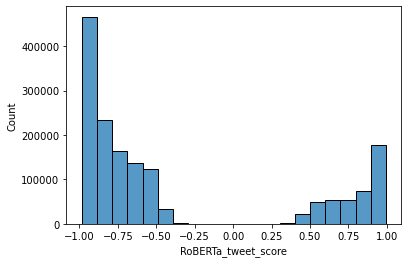

In [73]:
sns.histplot(data=comment[comment['RoBERTa_tweet_label']!='NEUTRAL'], x='RoBERTa_tweet_score', bins=20);

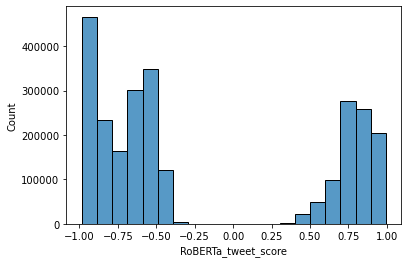

In [68]:
sns.histplot(data=comment, x='RoBERTa_tweet_score', bins=20);

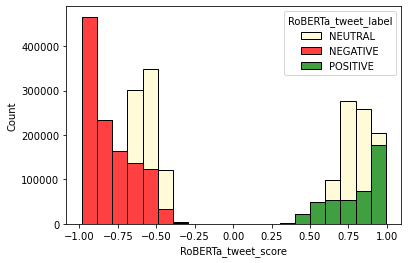

In [69]:
sns.histplot(data=comment, x='RoBERTa_tweet_score', bins=20, hue='RoBERTa_tweet_label', multiple="stack", hue_order=['NEUTRAL', 'NEGATIVE','POSITIVE'], palette=['lemonchiffon', 'red', 'green']);

### BERT_stars

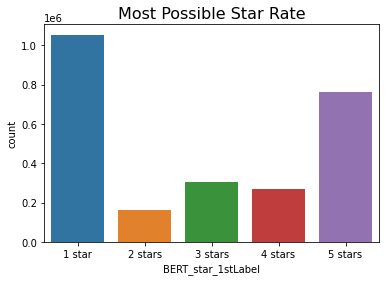

In [74]:
# # Barplot for BERT_star_1stLabel
sns.countplot(x='BERT_star_1stLabel', data=comment, order=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
plt.title('Most Possible Star Rate', size=16);

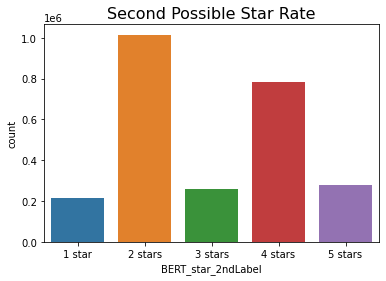

In [75]:
# Barplot for BERT_star_2ndLabel
sns.countplot(x='BERT_star_2ndLabel', data=comment, order=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
plt.title('Second Possible Star Rate', size=16);

In [76]:
# Create DataFrame for a stacked barplot
first_df = pd.DataFrame(comment['BERT_star_1stLabel']).rename(columns={'BERT_star_1stLabel': 'label'})
first_df['source'] = 'Most Possible'
second_df = pd.DataFrame(comment['BERT_star_2ndLabel']).rename(columns={'BERT_star_2ndLabel': 'label'})
second_df['source'] = 'Second Possible'
combined_df = first_df.append(second_df)

In [77]:
# combined_df.value_counts().unstack()

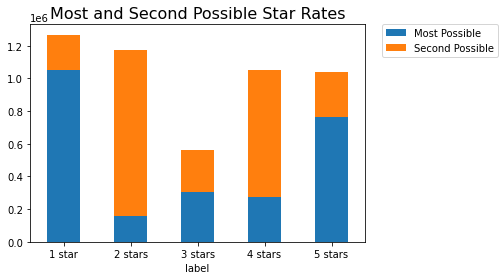

In [78]:
# stacked barplot for star rates
combined_df.value_counts().unstack().plot(kind='bar', stacked=True, rot=0)
plt.title('Most and Second Possible Star Rates', size=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

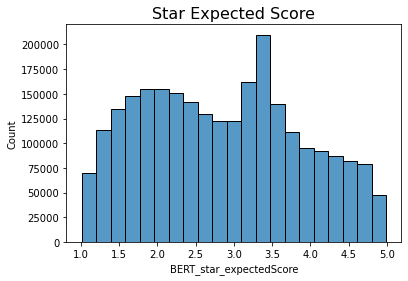

In [81]:
sns.histplot(comment['BERT_star_expectedScore'], bins=21)
plt.title('Star Expected Score', size=16);

In [88]:
comment['BERT_star_expectedTop2Score'] = comment.apply(lambda row: (int(row['BERT_star_1stLabel'][0]) * row['BERT_star_1stProb'] \
              + int(row['BERT_star_2ndLabel'][0]) * row['BERT_star_2ndProb']) \
              / (row['BERT_star_1stProb'] + row['BERT_star_2ndProb']), axis=1)

In [89]:
comment['BERT_star_1stLabel BERT_star_1stProb BERT_star_2ndLabel BERT_star_2ndProb BERT_star_expectedTop2Score'.split()]

,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedTop2Score
0,2 stars,0.446742,1 star,0.368282,1.548133
1,2 stars,0.423336,3 stars,0.314831,2.426504
2,4 stars,0.260640,3 stars,0.213096,3.550179
3,5 stars,0.307246,3 stars,0.219352,4.166909
4,5 stars,0.825189,4 stars,0.143059,4.852250
...,...,...,...,...,...
2863002,4 stars,0.543850,5 stars,0.351415,4.392526
2863003,5 stars,0.462686,4 stars,0.211353,4.686438
2863004,1 star,0.654665,2 stars,0.210814,1.243581
2863005,1 star,0.495808,2 stars,0.198165,1.285552


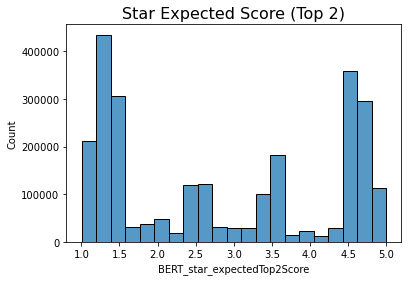

In [90]:
sns.histplot(comment['BERT_star_expectedTop2Score'], bins=21)
plt.title('Star Expected Score (Top 2)', size=16);

### BERT_emotion

In [219]:
comment.head(2)

,comment_message,post_id,comment_created_time,distilBERT_label,distilBERT_prob,distilBERT_score,RoBERTa_large_label,RoBERTa_large_prob,RoBERTa_large_score,RoBERTa_tweet_label,RoBERTa_tweet_prob,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedScore,BERT_emotion_sadness,BERT_emotion_joy,BERT_emotion_love,BERT_emotion_anger,BERT_emotion_fear,BERT_emotion_surprise,BERT_emotion_highest,BERT_emotion_highestScore,BERT_star_expectedTop2Score,RoBERTa_tweet_score
0,I've never liked the thought of Turkey. Even b...,198650096517_10154477788551518,2016-08-22 21:54:13+00:00,POSITIVE,0.990771,0.990771,NEGATIVE,0.998820,-0.998820,NEGATIVE,0.964068,2 stars,0.446742,1 star,0.368282,1.889820,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger,0.750804,1.548133,-0.964068
1,This is not acceptable. But we have let them g...,519305544814653_898285223583348,2015-03-30 23:02:28+00:00,NEGATIVE,0.998380,-0.998380,NEGATIVE,0.999445,-0.999445,NEGATIVE,0.926214,2 stars,0.423336,3 stars,0.314831,2.240447,0.028839,0.114509,0.003014,0.846426,0.005269,0.001943,anger,0.846426,2.426504,-0.926214


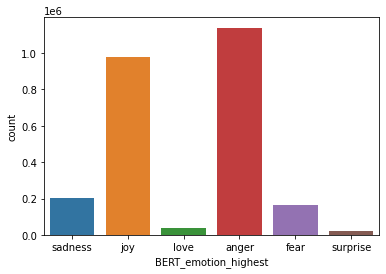

In [220]:
sns.countplot(x='BERT_emotion_highest', data=comment, order=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']);

In [15]:
emot_cols = ['BERT_emotion_sadness', 'BERT_emotion_joy', 'BERT_emotion_love', 'BERT_emotion_anger', 'BERT_emotion_fear', 'BERT_emotion_surprise', 'BERT_emotion_highest', 'BERT_emotion_highestScore']

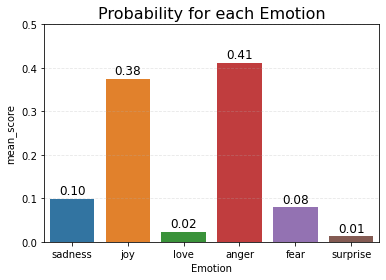

In [176]:
ser = comment[emot_cols[:-2]].mean()
x_labels = ser.index.map(lambda x: x.split('_')[-1])
plt.grid(True, alpha=0.3, ls='--')
barplot = sns.barplot(x=x_labels, y=ser.values);
_ = plt.title('Probability for each Emotion', size=16)
_ = plt.xlabel('Emotion')
_ = plt.ylabel('mean_score')
_ = plt.ylim([0.0, 0.50])
for i in range(len(ser)):
    t = barplot.text(x=i, y=ser.values[i]+0.01, s=f"{ser.values[i]:.2f}",\
                fontdict=dict(fontsize=12), horizontalalignment='center');

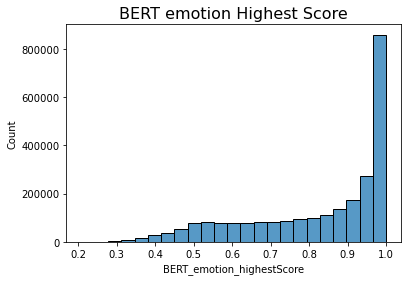

In [47]:
sns.histplot(comment['BERT_emotion_highestScore'], bins=23)
plt.title('BERT emotion Highest Score', size=16);

In [50]:
# Combine emotions to one score
comment['BERT_emotion_score'] = comment['BERT_emotion_highestScore'] * comment['BERT_emotion_highest'].apply(lambda x: -1 if x in ('sadness', 'anger', 'fear') else 1)

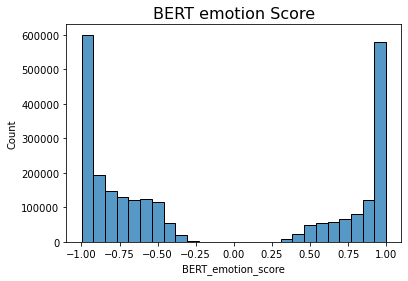

In [53]:
sns.histplot(comment['BERT_emotion_score'], bins=26)
plt.title('BERT emotion Score', size=16);

<a id="mathematical-method"></a>

## Score Distribution - Mathematical Method
Calculate the [Wasserstein Distance](https://en.wikipedia.org/wiki/Wasserstein_metric) between each distributions.<br>
In the case of 1-D distributions, it is equal to the area difference between the CDFs of the two distribution, as stated [here](https://youtu.be/U7xdiGc7IRU).

In [78]:
from scipy.stats import wasserstein_distance

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Standardize all Sentiment Scores
std_distilBERT_score = scaler.fit_transform(comment['distilBERT_score'].values.reshape(-1, 1)).reshape(-1,)
std_RoBERTa_large_score = scaler.fit_transform(comment['RoBERTa_large_score'].values.reshape(-1, 1)).reshape(-1,)
std_RoBERTa_tweet_score = scaler.fit_transform(comment['RoBERTa_tweet_score'].values.reshape(-1, 1)).reshape(-1,)
std_BERT_star_expectedTop2Score = scaler.fit_transform(comment['BERT_star_expectedTop2Score'].values.reshape(-1, 1)).reshape(-1,)
std_BERT_emotion_score = scaler.fit_transform(comment['BERT_emotion_score'].values.reshape(-1, 1)).reshape(-1,)

In [58]:
# Create co-wasserstein-distance Matrix
scores = [std_distilBERT_score, std_RoBERTa_large_score, std_RoBERTa_tweet_score, std_BERT_star_expectedTop2Score, std_BERT_emotion_score]
co_wdistance_matrix = []
for score1 in scores:
    co_wdistance_matrix.append([wasserstein_distance(score1, score2) for score2 in scores])

In [64]:
# co_wdistance_matrix

In [69]:
# Make co-wasserstein-distance Matrix a DataFrame
colnames = ['distilBERT', 'RoBERTa_large', 'RoBERTa_tweet', 'BERT_star', 'BERT_emotion']
co_wdistance_df = pd.DataFrame(co_wdistance_matrix, index=colnames, columns=colnames)
co_wdistance_df['mean_wdistance'] = co_wdistance_df.mean(axis=1)

In [88]:
# Styling and Show Result
cm = sns.light_palette("orange", as_cmap=True)
co_wdistance_df.style.background_gradient(cmap=cm, subset=colnames)

,distilBERT,RoBERTa_large,RoBERTa_tweet,BERT_star,BERT_emotion,mean_wdistance
distilBERT,0.000000,0.094798,0.235688,0.280457,0.146792,0.151547
RoBERTa_large,0.094798,0.000000,0.310408,0.298217,0.211318,0.182948
RoBERTa_tweet,0.235688,0.310408,0.000000,0.241955,0.121614,0.181933
BERT_star,0.280457,0.298217,0.241955,0.000000,0.176096,0.199345
BERT_emotion,0.146792,0.211318,0.121614,0.176096,0.000000,0.131164


We can see that BERT_emotion has the lowest mean distance from all other models.<br>
This means it serves as the "centroid" of all the models (in a space evaluated by Wasserstein distance).<br>
Thus, we can quantitatively say that **BERT_emotion is "the best proxy" of all models**.

<a id="sentiment-score"></a>

# Sentiment Score
[[Back to Navigation]](#navigation)

#### Join comments with page-related data, named `comment_joined`

In [278]:
# Page
page_info = pd.read_csv(r'input/page/1000-page-info.csv')
# Post
top1000page = pd.read_pickle(r'temp/post/original/top_1000_pages.pkl')
# Join data to get a big table
comment_joined = pd.merge(comment, top1000page, how='left', on='post_id')
comment_joined = pd.merge(comment_joined, page_info, how='left', on='page_id')

In [304]:
# comment_joined.shape

In [280]:
comment_joined.head(1)

,comment_message,post_id,comment_created_time,distilBERT_label,distilBERT_prob,distilBERT_score,RoBERTa_large_label,RoBERTa_large_prob,RoBERTa_large_score,RoBERTa_tweet_label,RoBERTa_tweet_prob,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedScore,BERT_emotion_sadness,BERT_emotion_joy,BERT_emotion_love,BERT_emotion_anger,BERT_emotion_fear,BERT_emotion_surprise,BERT_emotion_highest,BERT_emotion_highestScore,BERT_star_expectedTop2Score,RoBERTa_tweet_score,BERT_emotion_score,page_id,page_name_x,post_type,post_name,post_message,post_caption,post_picture,post_link,post_description,post_reactions,post_likes,post_comments,post_shares,post_created_time_CT,post_updated_time_CT,post_created_date_CT,post_updated_date_CT,post_created_time,post_updated_time,page_talking_about_count,page_name_y,category,type,type_sub,type_issue,fan_count,talking_about_count,page_url,total_like,total_comment,total_share,1:07:14,rank_1:7:14
0,I've never liked the thought of Turkey. Even b...,198650096517_10154477788551518,2016-08-22 21:54:13+00:00,POSITIVE,0.990771,0.990771,NEGATIVE,0.99882,-0.99882,NEGATIVE,0.964068,2 stars,0.446742,1 star,0.368282,1.88982,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger,0.750804,1.548133,-0.964068,-0.750804,1.986501e+11,PinkNews,link,"Despite bans, protests planned in Istanbul aft...",Brave demonstrators will take to the streets o...,pinknews.co.uk,https://external.xx.fbcdn.net/safe_image.php?d...,http://www.pinknews.co.uk/2016/08/21/despite-b...,Protests have been planned after the body of a...,NaN,283.0,13.0,47.0,2016-08-21 11:07:27+00:00,2016-08-22 16:54:13+00:00,2016-08-21,2016-08-22,2016-08-21 16:07:27+00:00,2016-08-22 21:54:13+00:00,132380.0,PinkNews,News/Media Website,media,website,NaN,296247.0,85578.0,https://www.facebook.com/pinknews,5920.0,981.0,3445.0,6101.7,615.0


In [ ]:
# Add polarity and subjectivity from SpacyTextBlob (for the first time)
# Don't need to run this code after this time.
import spacy
import pickle
from spacytextblob.spacytextblob import SpacyTextBlob
# nlp = spacy.load('en_core_web_lg')
# nlp.add_pipe("spacytextblob") # Add new component to the pipeline
# print(nlp.pipe_names) # uncomment to see all components
# comment_joined[['polarity', 'subjectivity', 'assessments']] = tuple((doc._.polarity, doc._.subjectivity, doc._.assessments) for doc in nlp.pipe(comment_joined['comment_message'])) # DONE

In [281]:
# Add polarity and subjectivity from previous results (using spacyTextBlob)
# From the second time on, run this code to get the same results from above cell instead.
cmt_sent = pd.read_pickle(r"temp/comment/original_with_sentiment/comment_0.pkl")
# print(cmt_sent.shape, comment_joined.shape) # different because some comments are brought back during the fasttext optimization
comment_joined = pd.merge(comment_joined, cmt_sent, on=['post_id', 'comment_created_time', 'comment_message'], how='left', suffixes=('', '_sent'))

# Sentiment Score Construction
* Aspect-based Sentiment: the same as BERT-emotion (the best proxy)
* Binary Sentiment Labels: Majority Vote (constructed below)
* Continuous Sentiment Score (constructed below)

### Binary Sentiment Labels: Majority Vote

In [372]:
# Create binary labels (POS, NEG) for RoBERTa-tweet, BERT-star, and BERT-emotion
comment_joined['RoBERTa_tweet_binaryLabel'] = comment_joined['RoBERTa_tweet_score'].apply(lambda x: 'POSITIVE' if x >= 0 else 'NEGATIVE')
comment_joined['BERT_star_binaryLabel'] = comment_joined['BERT_star_expectedTop2Score'].apply(lambda x: 'POSITIVE' if x >= 3 else 'NEGATIVE')
comment_joined['BERT_emotion_binaryLabel'] = comment_joined['BERT_emotion_score'].apply(lambda x: 'POSITIVE' if x >= 0 else 'NEGATIVE')
comment_joined['BERT_emotion_highestBinaryLabel'] = comment_joined['BERT_emotion_highest'].apply(lambda x: 'POSITIVE' if x in ('joy', 'love', 'surprise') else 'NEGATIVE')

In [374]:
# They are exactly the same!! Thus, there is no need to include 'BERT_emotion_highestBinaryLabel'
sum(comment_joined['BERT_emotion_binaryLabel'] != comment_joined['BERT_emotion_highestBinaryLabel'])

0

In [376]:
label_cols = ['distilBERT_label', 'RoBERTa_large_label', 'RoBERTa_tweet_label', 'BERT_star_1stLabel', 'BERT_emotion_highest', 'BERT_emotion_highestBinaryLabel', 'RoBERTa_tweet_binaryLabel', 'BERT_star_binaryLabel', 'BERT_emotion_binaryLabel']
comment_joined[label_cols].head(2)

,distilBERT_label,RoBERTa_large_label,RoBERTa_tweet_label,BERT_star_1stLabel,BERT_emotion_highest,BERT_emotion_highestBinaryLabel,RoBERTa_tweet_binaryLabel,BERT_star_binaryLabel,BERT_emotion_binaryLabel
0,POSITIVE,NEGATIVE,NEGATIVE,2 stars,anger,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
1,NEGATIVE,NEGATIVE,NEGATIVE,2 stars,anger,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE


In [388]:
# Majority Vote to decide the labels
voting_cols = ['distilBERT_label', 'RoBERTa_large_label', 'RoBERTa_tweet_binaryLabel', 'BERT_star_binaryLabel', 'BERT_emotion_binaryLabel']

,distilBERT_label,RoBERTa_large_label,RoBERTa_tweet_binaryLabel,BERT_star_binaryLabel,BERT_emotion_binaryLabel
0,POSITIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
1,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,NEGATIVE,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE
3,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
4,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE


In [391]:
%%time # This will take some time
comment_joined['majority_vote'] = comment_joined[voting_cols].mode(axis=1)

In [416]:
label_summary = pd.DataFrame(comment_joined[voting_cols + ['majority_vote']].apply(pd.Series.value_counts))

,distilBERT_label,RoBERTa_large_label,RoBERTa_tweet_binaryLabel,BERT_star_binaryLabel,BERT_emotion_binaryLabel,majority_vote
NEGATIVE,1482475,1418657,1637680,1372605,1509082,1491074
POSITIVE,1065995,1129813,910790,1175865,1039388,1057396


In [433]:
comment_joined[voting_cols + ['majority_vote']].head(5)

,distilBERT_label,RoBERTa_large_label,RoBERTa_tweet_binaryLabel,BERT_star_binaryLabel,BERT_emotion_binaryLabel,majority_vote
0,POSITIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
1,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,NEGATIVE,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
3,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
4,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE


### Continuous Sentiment Score: Averaging all results

In [544]:
score_cols = ['distilBERT_score', 'RoBERTa_large_score', 'RoBERTa_tweet_score', 'BERT_star_expectedTop2Score', 'BERT_emotion_score']
comment_joined[score_cols].head()

,distilBERT_score,RoBERTa_large_score,RoBERTa_tweet_score,BERT_star_expectedTop2Score,BERT_emotion_score
0,0.990771,-0.998820,-0.964068,1.548133,-0.750804
1,-0.998380,-0.999445,-0.926214,2.426504,-0.846426
2,-0.999461,-0.994421,-0.829197,3.550179,0.506111
3,-0.948954,-0.773979,0.564369,4.166909,0.925305
4,0.999525,0.998621,0.953136,4.852250,0.935860


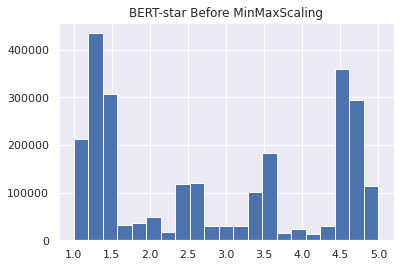

In [537]:
plt.hist(comment_joined['BERT_star_expectedTop2Score'], bins=21);
plt.title('BERT-star Before MinMaxScaling');

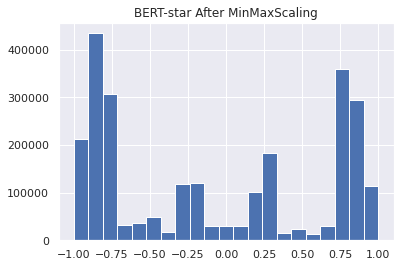

In [538]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler(feature_range=(-1, 1))
plt.hist(mm_scaler.fit_transform(comment_joined['BERT_star_expectedTop2Score'].values.reshape(-1, 1)), bins=21);
plt.title('BERT-star After MinMaxScaling');

In [541]:
# Perform MinMaxScaling on column BERT_star_expectedTop2Score
comment_joined['BERT_star_scaledScore'] = mm_scaler.fit_transform(comment_joined['BERT_star_expectedTop2Score'].values.reshape(-1, 1))

In [548]:
# The columns to take average
averaging_cols = ['distilBERT_score', 'RoBERTa_large_score', 'RoBERTa_tweet_score', 'BERT_star_scaledScore', 'BERT_emotion_score', 'majority_vote']

In [551]:
comment_joined[averaging_cols].head()

,distilBERT_score,RoBERTa_large_score,RoBERTa_tweet_score,BERT_star_scaledScore,BERT_emotion_score,majority_vote
0,0.990771,-0.998820,-0.964068,-0.727313,-0.750804,NEGATIVE
1,-0.998380,-0.999445,-0.926214,-0.287519,-0.846426,NEGATIVE
2,-0.999461,-0.994421,-0.829197,0.275097,0.506111,NEGATIVE
3,-0.948954,-0.773979,0.564369,0.583888,0.925305,POSITIVE
4,0.999525,0.998621,0.953136,0.927033,0.935860,POSITIVE


In [550]:
# They are not exactly the same, but close enough!
sum(comment_joined['BERT_star_scaledScore'].apply(lambda x: 'POSITIVE' if x >= 0 else 'NEGATIVE') != comment_joined['BERT_star_binaryLabel'])

126

In [560]:
# None of the values in comment_joined is zero
# comment_joined[averaging_cols[:-1]].applymap(lambda x: x == 0).sum() # uncomment to check

distilBERT_score         0
RoBERTa_large_score      0
RoBERTa_tweet_score      0
BERT_star_scaledScore    0
BERT_emotion_score       0
dtype: int64

In [569]:
def selective_mean(row):
    to_average = []
    if row['majority_vote'] == 'POSITIVE':
        to_average.extend(np.where(row[:-1] >= 0, row[:-1], 0))
    else: # NEGATIVE
        to_average.extend(np.where(row[:-1] < 0, row[:-1], 0))
    to_average = np.array(to_average)
    return np.mean(to_average[to_average != 0])

-0.8602513409298055

In [572]:
%%time
comment_joined['selective_mean'] = comment_joined[averaging_cols].apply(lambda row: selective_mean(row), axis=1)

CPU times: user 15min 33s, sys: 2.57 s, total: 15min 36s
Wall time: 16min 4s


In [575]:
comment_joined[averaging_cols + ['selective_mean']].head()

,distilBERT_score,RoBERTa_large_score,RoBERTa_tweet_score,BERT_star_scaledScore,BERT_emotion_score,majority_vote,selective_mean
0,0.990771,-0.998820,-0.964068,-0.727313,-0.750804,NEGATIVE,-0.860251
1,-0.998380,-0.999445,-0.926214,-0.287519,-0.846426,NEGATIVE,-0.811597
2,-0.999461,-0.994421,-0.829197,0.275097,0.506111,NEGATIVE,-0.941026
3,-0.948954,-0.773979,0.564369,0.583888,0.925305,POSITIVE,0.691187
4,0.999525,0.998621,0.953136,0.927033,0.935860,POSITIVE,0.962835


In [ ]:
comment_joined.to_pickle(r'temp/comment/comment_joined_0.pkl')

In [ ]:
comment_joined = pd.read_pickle(r'temp/comment/comment_joined_0.pkl')

In [63]:
comment_joined.head(2)

,comment_message,post_id,comment_created_time,distilBERT_label,distilBERT_prob,distilBERT_score,RoBERTa_large_label,RoBERTa_large_prob,RoBERTa_large_score,RoBERTa_tweet_label,RoBERTa_tweet_prob,BERT_star_1stLabel,BERT_star_1stProb,BERT_star_2ndLabel,BERT_star_2ndProb,BERT_star_expectedScore,BERT_emotion_sadness,BERT_emotion_joy,BERT_emotion_love,BERT_emotion_anger,BERT_emotion_fear,BERT_emotion_surprise,BERT_emotion_highest,BERT_emotion_highestScore,BERT_star_expectedTop2Score,RoBERTa_tweet_score,BERT_emotion_score,page_id,page_name_x,post_type,post_name,post_message,post_caption,post_picture,post_link,post_description,post_reactions,post_likes,post_comments,post_shares,post_created_time_CT,post_updated_time_CT,post_created_date_CT,post_updated_date_CT,post_created_time,post_updated_time,page_talking_about_count,page_name_y,category,type,type_sub,type_issue,fan_count,talking_about_count,page_url,total_like,total_comment,total_share,1:07:14,rank_1:7:14,polarity,subjectivity,assessments,RoBERTa_tweet_binaryLabel,BERT_star_binaryLabel,BERT_emotion_binaryLabel,BERT_emotion_highestBinaryLabel,majority_vote,BERT_star_scaledScore,selective_mean
0,I've never liked the thought of Turkey. Even b...,198650096517_10154477788551518,2016-08-22 21:54:13+00:00,POSITIVE,0.990771,0.990771,NEGATIVE,0.998820,-0.998820,NEGATIVE,0.964068,2 stars,0.446742,1 star,0.368282,1.889820,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger,0.750804,1.548133,-0.964068,-0.750804,1.986501e+11,PinkNews,link,"Despite bans, protests planned in Istanbul aft...",Brave demonstrators will take to the streets o...,pinknews.co.uk,https://external.xx.fbcdn.net/safe_image.php?d...,http://www.pinknews.co.uk/2016/08/21/despite-b...,Protests have been planned after the body of a...,NaN,283.0,13.0,47.0,2016-08-21 11:07:27+00:00,2016-08-22 16:54:13+00:00,2016-08-21,2016-08-22,2016-08-21 16:07:27+00:00,2016-08-22 21:54:13+00:00,132380.0,PinkNews,News/Media Website,media,website,NaN,296247.0,85578.0,https://www.facebook.com/pinknews,5920.0,981.0,3445.0,6101.7,615.0,0.014583,0.766667,"[([never, liked], -0.3, 0.8, None), ([more], 0...",NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,-0.727313,-0.860251
1,This is not acceptable. But we have let them g...,519305544814653_898285223583348,2015-03-30 23:02:28+00:00,NEGATIVE,0.998380,-0.998380,NEGATIVE,0.999445,-0.999445,NEGATIVE,0.926214,2 stars,0.423336,3 stars,0.314831,2.240447,0.028839,0.114509,0.003014,0.846426,0.005269,0.001943,anger,0.846426,2.426504,-0.926214,-0.846426,5.193055e+14,Conservative Tribune,link,Wow. Michelle Obama Has a Racist Message for W...,Michelle Obama just sent a shockingly racist m...,conservativetribune.com,https://external.xx.fbcdn.net/safe_image.php?d...,http://conservativetribune.com/obama-racist-me...,Nobody's reported on this...,1347.0,1347.0,1690.0,927.0,2015-03-30 11:30:01+00:00,2015-04-07 14:32:03+00:00,2015-03-30,2015-04-07,2015-03-30 16:30:01+00:00,2015-04-07 19:32:03+00:00,307100.0,Conservative Tribune,Media/News/Publishing,media,website,NaN,2947333.0,640759.0,https://www.facebook.com/theconservativetribune,414111.0,62059.0,313517.0,523776.2,15.0,0.000000,0.000000,[],NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,-0.287519,-0.811597


<a id="analytical-results"></a>

# Analytical Results
[[Back to Navigation]](#navigation)

The best way to validate any Sentiment Score is to add tags by human(工人智慧), but this is not probable for this project unless there's budget for it.<br>
In this regard, the second best (and most realistic) way is to check by ourselves __if the Sentiment Score "MAKES SENSE"__. Therefore, I have designed several tests to examine their sensibleness.<br>

1. **Sentiment Score Results in US Presidential Election in 2016**<br>
    * [Aspect-based Sentiment](#aspect-based-sentiment)<br>
    * [Binary Sentiment Labels](#binary-sentiment-labels)<br>
    * [Continuous Sentiment Score](#continuous-sentiment-score)<br>
    * [Social Listener - Continuous Sentiment Score](#social-listener-continuous-sentiment-score)<br>
    * [Social Listener - Aspect-based Sentiment](#social-listener-aspect-based-sentiment)<br>
        * [by Trump/Hillary](#social-listener-aspect-based-sentiment-by-trump-hillary)<br>
        * [by Emotion (joy, love, surprise, sadness, anger, fear)](#social-listener-aspect-based-sentiment-by-emotion)<br><br>
2. **Compare with spacytextblob the [Bubbleplot that clusters posts based on page types](#bubbleplot)**<br><br>
3. Reproduce New York Times US Map (Future Work)
    * Calculate average comment sentiment score for each Trump's/Hillary's post
    * group the (score, posts) pairs by district using TIMEZONE
    * More data was needed to accomplish this; unfortunately unrealistic in this project
    
I hereby present the first two.<br>
#### Full description is included in USFB_quick_results.pdf.

### Prepare the data for analysis

In [345]:
page_info.loc[(page_info['type']=='group') & (page_info['category']=='Community'), ['page_name', 'category', 'type', 'type_sub', 'type_issue']]

,page_name,category,type,type_sub,type_issue
47,Americans Against The Republican Party,Community,group,NaN,NaN
52,God Bless the President of the United States,Community,group,NaN,NaN
74,Obama is the Worst President in US History,Community,group,NaN,NaN
88,I will vote for Obama in 2012.,Community,group,NaN,NaN
92,US Uncut,Community,group,NaN,NaN
...,...,...,...,...,...
949,Last American Patriots,Community,group,NaN,NaN
956,Red White Blue News,Community,group,NaN,NaN
959,The Middle Class Will Be Heard,Community,group,NaN,NaN
986,Going to Hell in Every Religion,Community,group,NaN,NaN


In [64]:
trump = comment_joined[(comment_joined['page_name_y'] == 'Donald J. Trump')].rename(columns={'page_name_y': 'page_name'}).copy()
hillary = comment_joined[(comment_joined['page_name_y'] == 'Hillary Clinton')].rename(columns={'page_name_y': 'page_name'}).copy()
trump_hillary = comment_joined[(comment_joined['page_name_y'] == 'Donald J. Trump') | (comment_joined['page_name_y'] == 'Hillary Clinton')].rename(columns={'page_name_y': 'page_name'}).copy()

In [65]:
trump.shape
hillary.shape

(24096, 70)

(12116, 70)

In [66]:
trump_hillary.shape

(36212, 70)

<a id="aspect-based-sentiment"></a>

### Aspect-based Sentiment
[[Back to Analytical Results]](#analytical-results)

In [70]:
# Previously, from some blocks above... Extract the columns needed
from scipy.stats import mode
emot_cols = ['BERT_emotion_sadness', 'BERT_emotion_joy', 'BERT_emotion_love', 'BERT_emotion_anger', 'BERT_emotion_fear', 'BERT_emotion_surprise', 'BERT_emotion_highest', 'BERT_emotion_highestScore']

In [71]:
emotion_cols = emot_cols[:-2]
agg_dict = {emot: 'mean' for emot in emotion_cols}
agg_dict['BERT_emotion_highest'] = lambda x: mode(x)[0]
rename_dict = {emot: '_'.join(emot.split('_')[::2]) for emot in emotion_cols}
trump_hillary.groupby(['page_name'])[emotion_cols + ['BERT_emotion_highest']].agg(agg_dict).rename(columns=rename_dict)

,BERT_sadness,BERT_joy,BERT_love,BERT_anger,BERT_fear,BERT_surprise,BERT_emotion_highest
page_name,,,,,,,
Donald J. Trump,0.074530,0.535005,0.019349,0.321067,0.04240,0.007648,joy
Hillary Clinton,0.087551,0.489037,0.021095,0.350155,0.04531,0.006852,joy


In [72]:
comment_joined[emotion_cols + ['BERT_emotion_highest']].head().rename(columns=rename_dict)

,BERT_sadness,BERT_joy,BERT_love,BERT_anger,BERT_fear,BERT_surprise,BERT_emotion_highest
0,0.001692,0.034497,0.203237,0.750804,0.002372,0.007398,anger
1,0.028839,0.114509,0.003014,0.846426,0.005269,0.001943,anger
2,0.019148,0.506111,0.004474,0.462502,0.005904,0.001861,joy
3,0.033257,0.925305,0.003607,0.033050,0.003652,0.001128,joy
4,0.001002,0.935860,0.061434,0.000601,0.000400,0.000703,joy


<a id="binary-sentiment-labels"></a>

### Binary Sentiment Labels: Majority Vote
[[Back to Analytical Results]](#analytical-results)

In [73]:
trump_hillary_mv = pd.DataFrame(trump_hillary.groupby(['page_name', 'post_id'])['majority_vote'].agg(lambda x: mode(x)[0]))
trump_hillary_mv

majority_vote
page_name       post_id                                      
Donald J. Trump 153080620724_10154994141850725       NEGATIVE
                153080620724_10154994200030725       POSITIVE
                153080620724_10154997068045725       POSITIVE
                153080620724_10155009354115725       POSITIVE
                153080620724_10155024375830725       POSITIVE
...                                                       ...
Hillary Clinton 889307941125736_999748683414994      NEGATIVE
                889307941125736_999824783407384      NEGATIVE
                889307941125736_999835160073013      NEGATIVE
                889307941125736_999865193403343      NEGATIVE
                889307941125736_999866820069847      POSITIVE

[6534 rows x 1 columns]

In [74]:
trump.groupby('post_id').agg({'majority_vote': lambda x: mode(x)[0]}).value_counts(normalize=True).apply(lambda x: f'{100 * x:.2f}%').to_frame('pct')

,pct
majority_vote,
NEGATIVE,55.40%
POSITIVE,44.60%


In [75]:
hillary.groupby('post_id').agg({'majority_vote': lambda x: mode(x)[0]}).value_counts(normalize=True).apply(lambda x: f'{100 * x:.2f}%').to_frame('pct')

,pct
majority_vote,
NEGATIVE,68.60%
POSITIVE,31.40%


<a id="continuous-sentiment-score"></a>

### Continuous Sentiment Scores: Selective Mean
[[Back to Analytical Results]](#analytical-results)

In [76]:
trump_hillary.groupby(['page_name', 'post_id'])['selective_mean'].mean().to_frame()

selective_mean
page_name       post_id                                        
Donald J. Trump 153080620724_10154994141850725        -0.597309
                153080620724_10154994200030725         0.790403
                153080620724_10154997068045725         0.458304
                153080620724_10155009354115725         0.831108
                153080620724_10155024375830725         0.901359
...                                                         ...
Hillary Clinton 889307941125736_999748683414994       -0.861027
                889307941125736_999824783407384       -0.782836
                889307941125736_999835160073013       -0.913890
                889307941125736_999865193403343       -0.009094
                889307941125736_999866820069847        0.817181

[6534 rows x 1 columns]

In [77]:
trump_hillary.groupby(['page_name'])['selective_mean'].mean().to_frame()

,selective_mean
page_name,
Donald J. Trump,0.024271
Hillary Clinton,-0.139765


<a id="social-listener-continuous-sentiment-score"></a>

## Social Listener - Continuous Sentiment Score
[[Back to Analytical Results]](#analytical-results)

In [78]:
sent_cols = emotion_cols + ['BERT_emotion_highest', 'majority_vote', 'selective_mean']

In [79]:
trump_sent_by_time = pd.merge(trump.groupby(['post_id'])['selective_mean'].mean().to_frame().reset_index(), trump_hillary[['post_id', 'post_created_date_CT'] + sent_cols], how='left', on='post_id')
trump_sent_by_time.drop(columns='selective_mean_x', inplace=True)
trump_sent_by_time.rename(columns={'selective_mean_y': 'selective_mean'}, inplace=True)
trump_sent_by_time.set_index('post_created_date_CT', inplace=True)
trump_sent_by_time = trump_sent_by_time.resample('M', kind='period').mean()
trump_sent_by_time.reset_index(inplace=True)

In [80]:
hillary_sent_by_time = pd.merge(hillary.groupby(['post_id'])['selective_mean'].mean().to_frame().reset_index(), trump_hillary[['post_id', 'post_created_date_CT'] + sent_cols], how='left', on='post_id')
hillary_sent_by_time.drop(columns='selective_mean_x', inplace=True)
hillary_sent_by_time.rename(columns={'selective_mean_y': 'selective_mean'}, inplace=True)
hillary_sent_by_time.set_index('post_created_date_CT', inplace=True)
hillary_sent_by_time = hillary_sent_by_time.resample('M', kind='period').mean()
hillary_sent_by_time.reset_index(inplace=True)

In [102]:
sns.set_style('darkgrid')

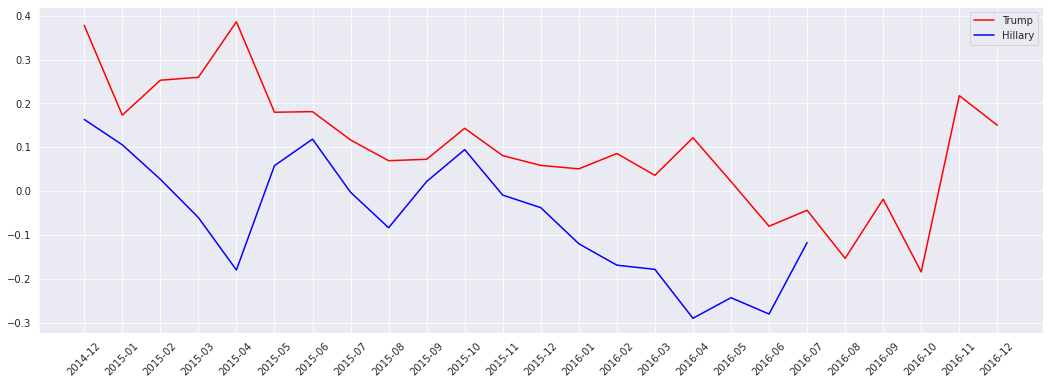

In [115]:
plt.figure(figsize=(18, 6))
plt.plot('selective_mean', data=trump_sent_by_time, label='Trump', color='red')
plt.plot('selective_mean', data=hillary_sent_by_time, label='Hillary', color='blue')
plt.xticks(range(0, trump_sent_by_time.shape[0]), trump_sent_by_time['post_created_date_CT'], rotation=45)
plt.legend();

<a id="social-listener-aspect-based-sentiment"></a>

## Social Listener - Aspect-based Sentiment
[[Back to Analytical Results]](#analytical-results)

<a id="social-listener-aspect-based-sentiment-by-trump-hillary"></a>
### by Trump/Hillary

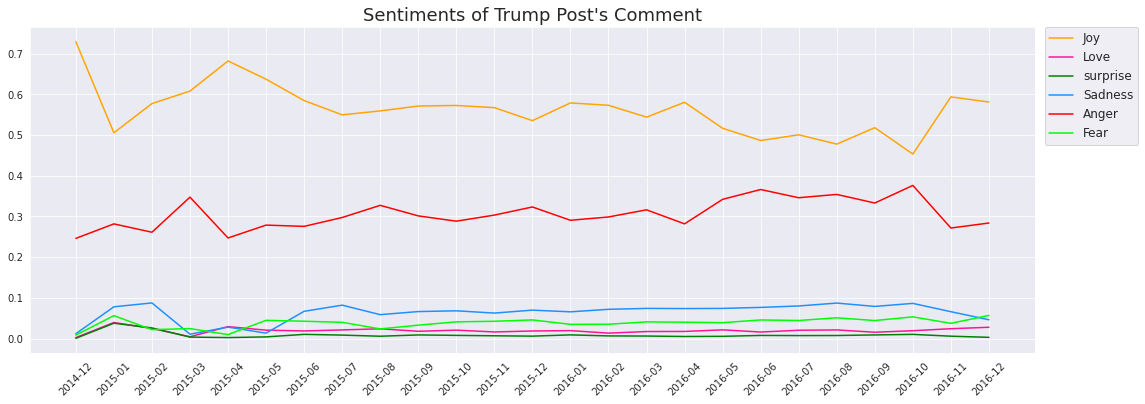

In [159]:
plt.figure(figsize=(18, 6))
plt.plot('BERT_emotion_joy', data=trump_sent_by_time, label='Joy', color='orange')
plt.plot('BERT_emotion_love', data=trump_sent_by_time, label='Love', color='deeppink')
plt.plot('BERT_emotion_surprise', data=trump_sent_by_time, label='surprise', color='green')
plt.plot('BERT_emotion_sadness', data=trump_sent_by_time, label='Sadness', color='dodgerblue')
plt.plot('BERT_emotion_anger', data=trump_sent_by_time, label='Anger', color='red')
plt.plot('BERT_emotion_fear', data=trump_sent_by_time, label='Fear', color='lime')
plt.xticks(range(0, trump_sent_by_time.shape[0]), trump_sent_by_time['post_created_date_CT'], rotation=45)
plt.title("Sentiments of Trump Post's Comment", size=18)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=12);

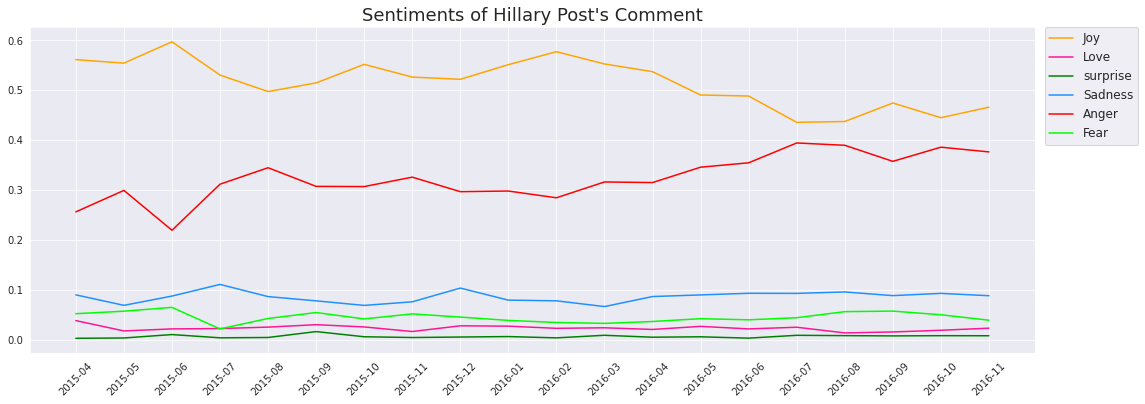

In [160]:
plt.figure(figsize=(18, 6))
plt.plot('BERT_emotion_joy', data=hillary_sent_by_time, label='Joy', color='orange')
plt.plot('BERT_emotion_love', data=hillary_sent_by_time, label='Love', color='deeppink')
plt.plot('BERT_emotion_surprise', data=hillary_sent_by_time, label='surprise', color='green')
plt.plot('BERT_emotion_sadness', data=hillary_sent_by_time, label='Sadness', color='dodgerblue')
plt.plot('BERT_emotion_anger', data=hillary_sent_by_time, label='Anger', color='red')
plt.plot('BERT_emotion_fear', data=hillary_sent_by_time, label='Fear', color='lime')
plt.xticks(range(0, hillary_sent_by_time.shape[0]), hillary_sent_by_time['post_created_date_CT'], rotation=45)
plt.title("Sentiments of Hillary Post's Comment", size=18)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=12);

<a id="social-listener-aspect-based-sentiment-by-emotion"></a>
### by Emotion (joy, love, surprise, sadness, anger, fear)

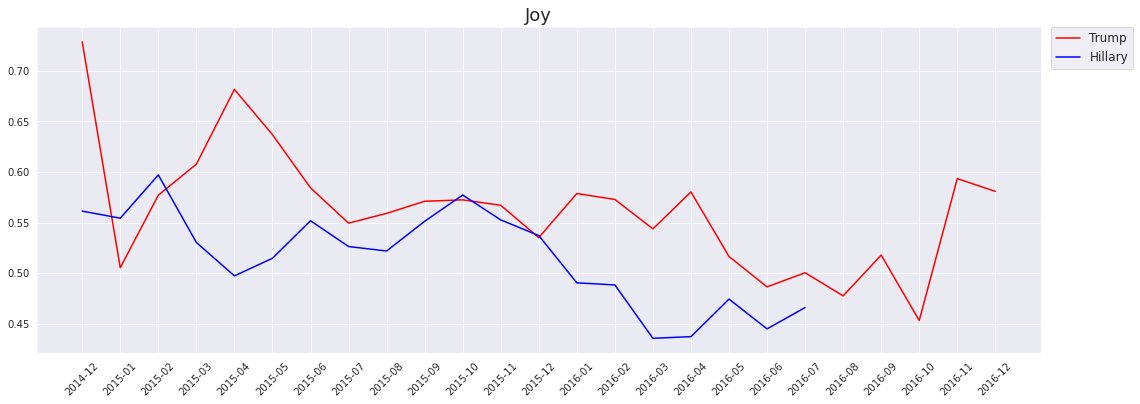

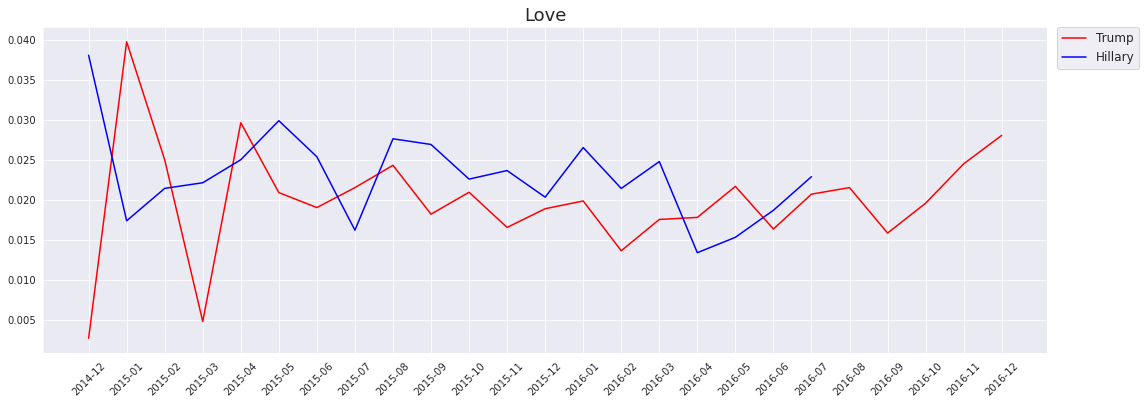

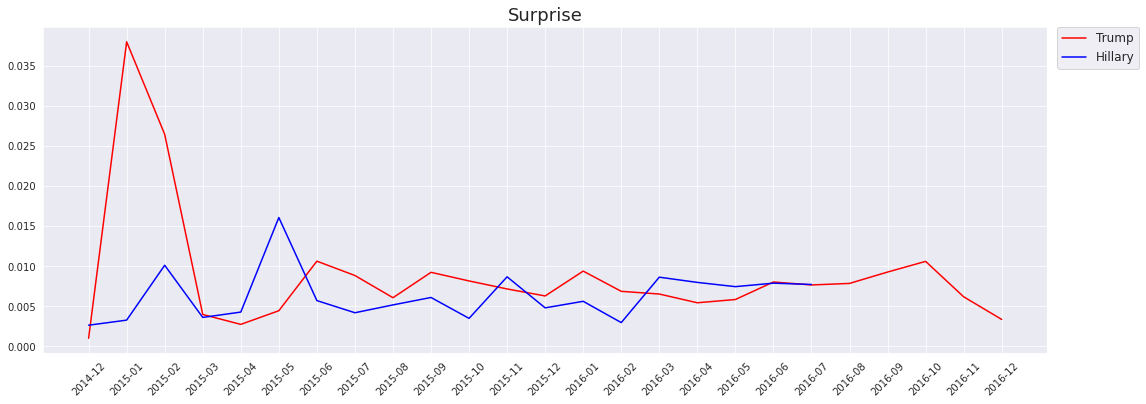

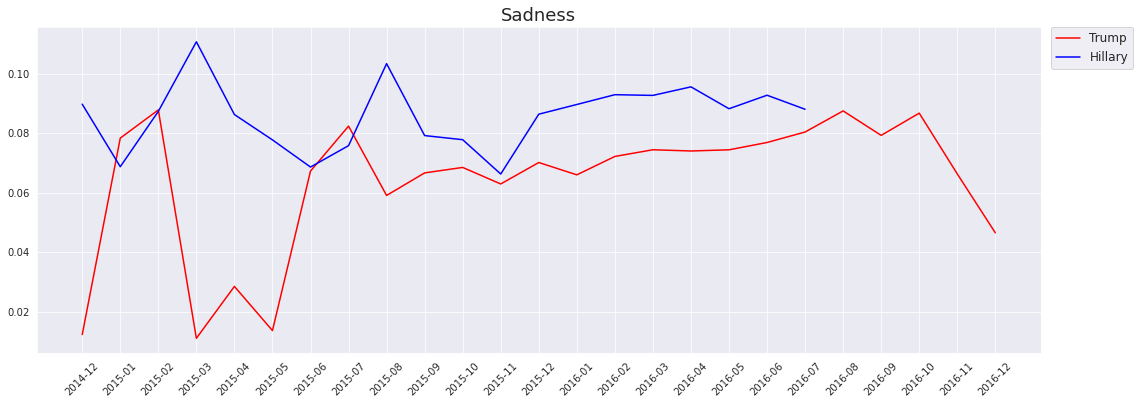

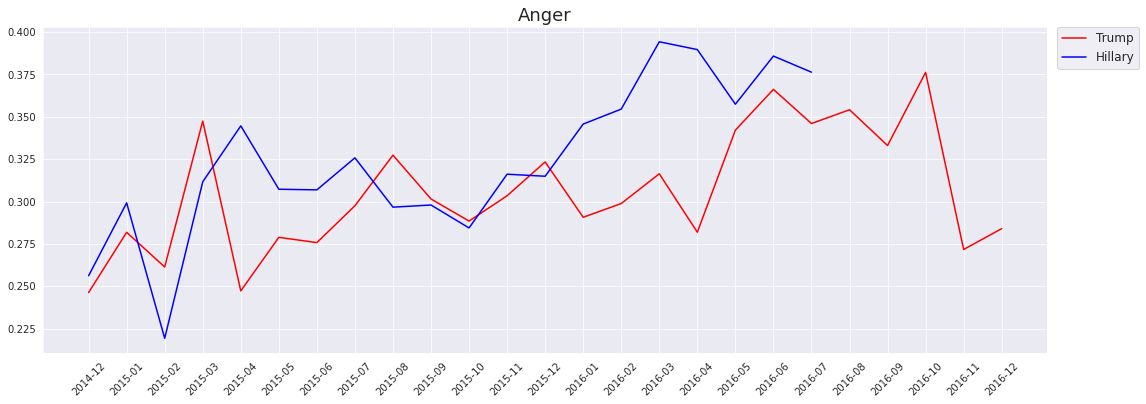

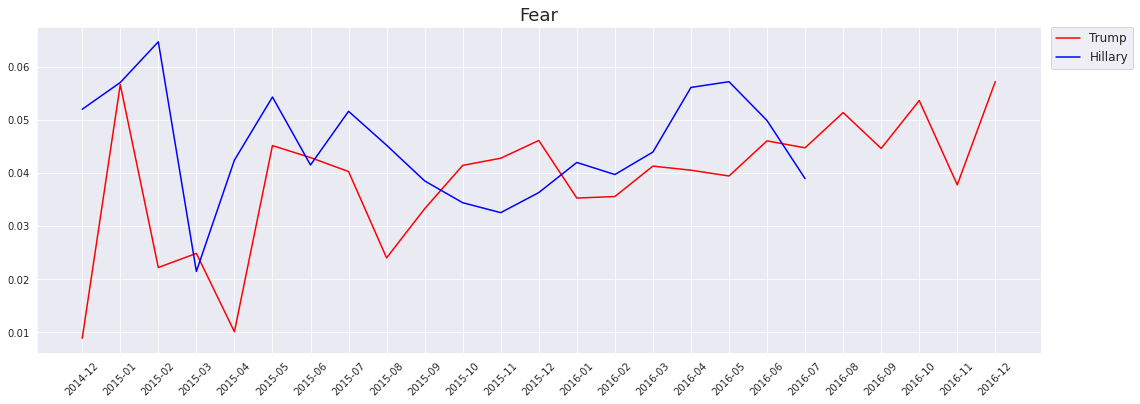

In [232]:
def emotion_lineplot(emotion):
    plt.figure(figsize=(18, 6))
    plt.plot('BERT_emotion_' + emotion, data=trump_sent_by_time, label='Trump', color='red')
    plt.plot('BERT_emotion_' + emotion, data=hillary_sent_by_time, label='Hillary', color='blue')
    plt.xticks(range(0, trump_sent_by_time.shape[0]), trump_sent_by_time['post_created_date_CT'], rotation=45)
    plt.title(emotion.capitalize(), size=18)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=12);
    
for emotion in 'joy love surprise sadness anger fear'.split():
    emotion_lineplot(emotion)

In [226]:
# Get Sentiment by time for Trump and Hillary
trump_hillary_sent_by_time = trump_hillary[['post_id', 'post_created_date_CT', 'page_name'] + sent_cols].copy()
# Melt the DataFrame: transform the wide-format data into long-format data
trump_hillary_sent_by_time = trump_hillary_sent_by_time.melt(id_vars=['post_id', 'post_created_date_CT', 'page_name'], \
                                                            var_name='emotion', value_name='prob')
# Get rid of useless columns
trump_hillary_sent_by_time = trump_hillary_sent_by_time[~trump_hillary_sent_by_time['emotion'].isin(['majority_vote', 'selective_mean', 'BERT_emotion_highest'])]
# Beautify the emotion names
trump_hillary_sent_by_time['emotion'] = trump_hillary_sent_by_time['emotion'].apply(lambda x: x.split('_')[-1])
# Cast the datatypes
trump_hillary_sent_by_time['prob'] = trump_hillary_sent_by_time['prob'].astype('float')
# Get monthly period from date
trump_hillary_sent_by_time['post_created_period'] = trump_hillary_sent_by_time['post_created_date_CT'].dt.to_period('M')
trump_hillary_sent_by_time['post_created_period'] = trump_hillary_sent_by_time['post_created_period'].astype('str')
# Aggregate prob by month(period), and only keep useful columns
trump_hillary_sent_by_time = trump_hillary_sent_by_time.groupby(['post_created_period', 'page_name', 'emotion'])['prob'].mean().to_frame().reset_index()

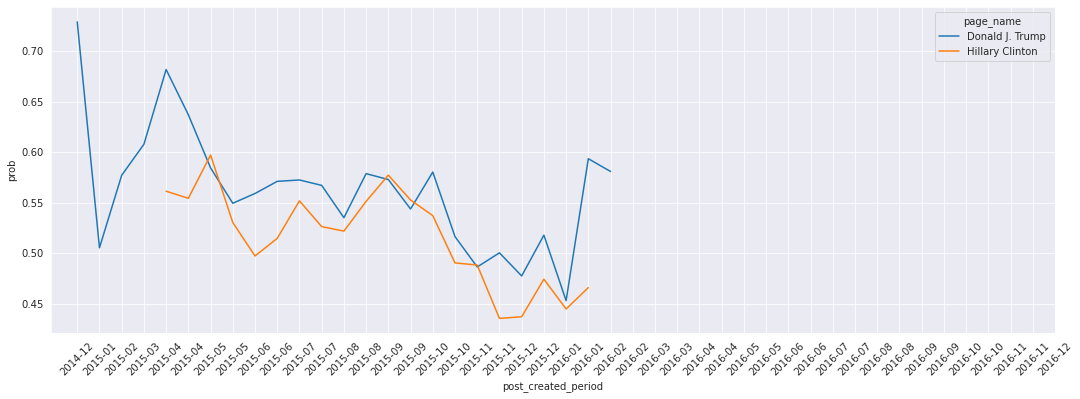

In [233]:
plt.figure(figsize=(18, 6))
data = trump_hillary_sent_by_time[trump_hillary_sent_by_time.emotion == 'joy'].copy()
sns.lineplot(data=data, x='post_created_period', y='prob', hue='page_name')
plt.xticks(range(0, data.shape[0]), data['post_created_period'], rotation=45);

<a id="bubbleplot"></a>

## Bubbleplot for BERT models
[[Back to Analytical Results]](#analytical-results)

The description are included in USFB_full_presenttion.pdf

In [349]:
cols = ['type', 'type_sub', 'comment_message', 'subjectivity', 'polarity', 'distilBERT_score', 'RoBERTa_large_score', 'RoBERTa_tweet_score', 'BERT_star_expectedTop2Score', 'BERT_emotion_sadness', 'BERT_emotion_joy', 'BERT_emotion_love', 'BERT_emotion_anger', 'BERT_emotion_fear', 'BERT_emotion_surprise', 'BERT_emotion_score']
# Creat agg_dict for groupby aggregation
agg_dict = {colname: 'mean' for colname in cols[3:]}
agg_dict['comment_message'] = 'count'
# Create rename_dict for renaming columns
rename_dict = {colname: '_'.join(colname.split('_')[:-1]) if colname.lower().endswith('score') else '_'.join(colname.split('_')[::2]) for colname in cols[5:]}
rename_dict['comment_message'] = 'comment_count'
rename_dict['polarity'] = 'spacyTextBlob'

In [351]:
# agg_dict

In [353]:
# rename_dict

In [354]:
# Aggregate comment_sm_joined grouped by type and type_sub
model_sent_by_type = comment_joined[cols].groupby(['type', 'type_sub'], dropna=False).agg(agg_dict)
# Rename the columns for readability
model_sent_by_type.rename(columns=rename_dict, inplace=True)
# Calculate percentage for each type(_sub)
comment_total_count = model_sent_by_type['comment_count'].sum()
model_sent_by_type['comment_pct'] = model_sent_by_type['comment_count'].apply(lambda x: f'{x / comment_total_count:.2%}')
# Get column: page_type_sub
model_sent_by_type.reset_index(inplace=True)
model_sent_by_type.fillna('NaN', inplace=True)
model_sent_by_type['page_type_sub'] = model_sent_by_type['type'] + '-' + model_sent_by_type['type_sub']
model_sent_by_type.set_index(['type', 'type_sub'], inplace=True)
# Styling
# red_cm = sns.light_palette("red", as_cmap=True)
# model_sent_by_type.style.background_gradient(cmap=red_cm, subset=['polarity', 'subjectivity'])

In [355]:
model_sent_by_type

subjectivity  spacyTextBlob  distilBERT  RoBERTa_large  \
type   type_sub                                                             
figure journalist      0.353367       0.055642   -0.215620      -0.186013   
       politician      0.344656       0.084603   -0.112248      -0.086838   
group  NaN             0.337651       0.027632   -0.302028      -0.272506   
media  magazine        0.330566       0.066559   -0.060921       0.038564   
       newspaper       0.343622       0.047789   -0.217606      -0.169150   
       radio           0.337214       0.056103   -0.163559      -0.093582   
       tv              0.356553       0.058540   -0.165066      -0.117391   
       website         0.314981       0.035627   -0.160056      -0.123360   
others NaN             0.246751       0.095677    0.246797       0.472851   
NaN    NaN             0.353471       0.047845   -0.195449      -0.141154   

                   RoBERTa_tweet  BERT_star  BERT_sadness  BERT_joy  \
type   type_sub                                                       
figure journalist      -0.249683   2.812889      0.095791  0.398687   
       politician      -0.194260   2.898858      0.086767  0.476821   
group  NaN             -0.349763   2.718216      0.095097  0.389354   
media  magazine        -0.034044   2.968121      0.105625  0.379489   
       newspaper       -0.197107   2.766549      0.109876  0.360854   
       radio           -0.143345   2.854895      0.106997  0.378602   
       tv              -0.165325   2.852793      0.112246  0.381013   
       website         -0.196514   2.832914      0.095880  0.357187   
others NaN              0.294074   3.406233      0.074389  0.352596   
NaN    NaN             -0.185051   2.819800      0.102026  0.369318   

                   BERT_love  BERT_anger  BERT_fear  BERT_surprise  \
type   type_sub                                                      
figure journalist   0.022704    0.402161   0.066778       0.013878   
       politician   0.019951    0.359175   0.047411       0.009875   
group  NaN          0.017985    0.426425   0.059037       0.012102   
media  magazine     0.030477    0.376641   0.093893       0.013876   
       newspaper    0.022389    0.407992   0.085120       0.013770   
       radio        0.023678    0.390007   0.086051       0.014663   
       tv           0.026472    0.386456   0.081009       0.012803   
       website      0.020490    0.432260   0.081882       0.012301   
others NaN          0.033888    0.399897   0.127584       0.011645   
NaN    NaN          0.025249    0.412140   0.077477       0.013790   

                   BERT_emotion  comment_count comment_pct      page_type_sub  
type   type_sub                                                                
figure journalist     -0.084994         187109       7.34%  figure-journalist  
       politician      0.055118         108295       4.25%  figure-politician  
group  NaN            -0.115398         268824      10.55%          group-NaN  
media  magazine       -0.092062          73842       2.90%     media-magazine  
       newspaper      -0.146131          89896       3.53%    media-newspaper  
       radio          -0.107682          29370       1.15%        media-radio  
       tv             -0.107887         600932      23.58%           media-tv  
       website        -0.161297        1074095      42.15%      media-website  
others NaN            -0.122758         100615       3.95%         others-NaN  
NaN    NaN            -0.132167          15492       0.61%            NaN-NaN

In [333]:
# Define a function for plotting the Sentiment Scores
sns.set(font_scale=1)
def bubbleplot(sent_score='spacyTextBlob'):
    assert sent_score in model_sent_by_type # input must be an existing column name
    plt.figure(figsize=(12, 8))
    plt.title(f'{sent_score} Sentiment Score\n', size=16)
    ax = sns.scatterplot(x=sent_score, y='subjectivity', data=model_sent_by_type, hue='page_type_sub', size='comment_count', alpha=0.5, sizes=(10, 10000))
    #For each point, add a text inside the bubble
    for line in range(0,model_sent_by_type.shape[0]):
        annot = model_sent_by_type.page_type_sub[line]
        if annot != 'NaN-NaN':
            ax.text(model_sent_by_type[sent_score][line], model_sent_by_type.subjectivity[line], annot, horizontalalignment='center', size='medium', color='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15);

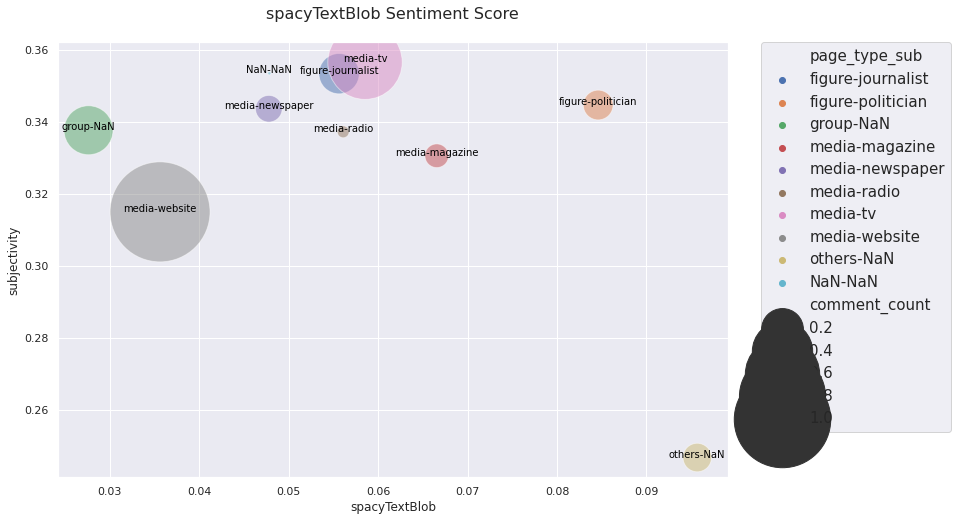

In [314]:
# Bubbleplot for spacyTextBlob (Naive Bayes Classifier)
bubbleplot('spacyTextBlob')

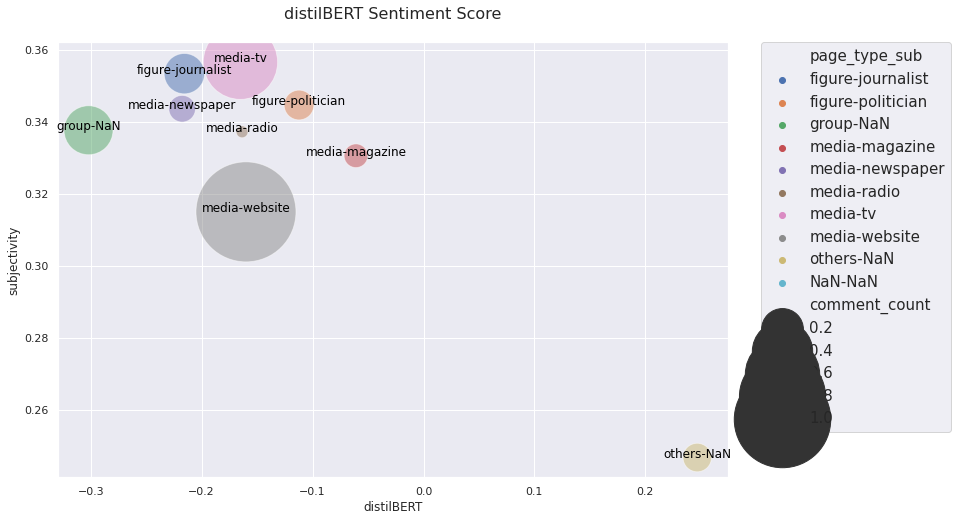

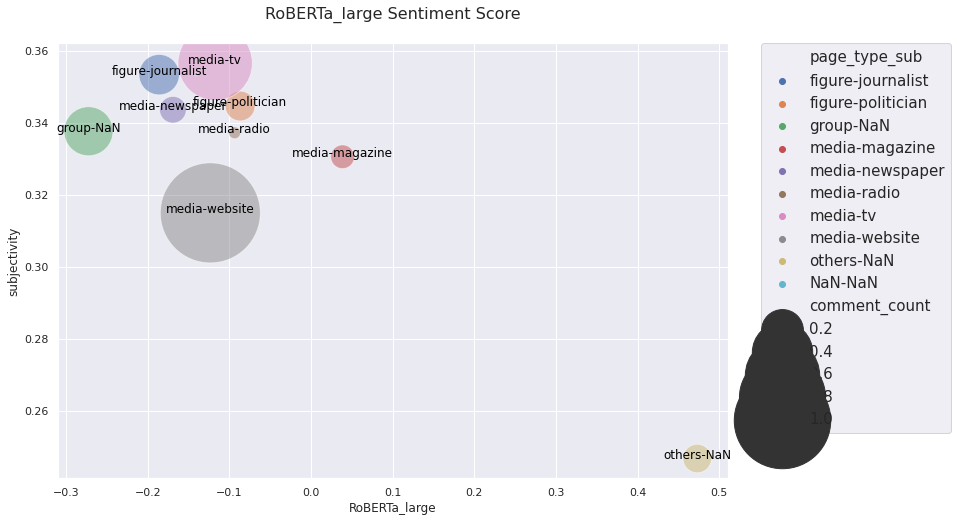

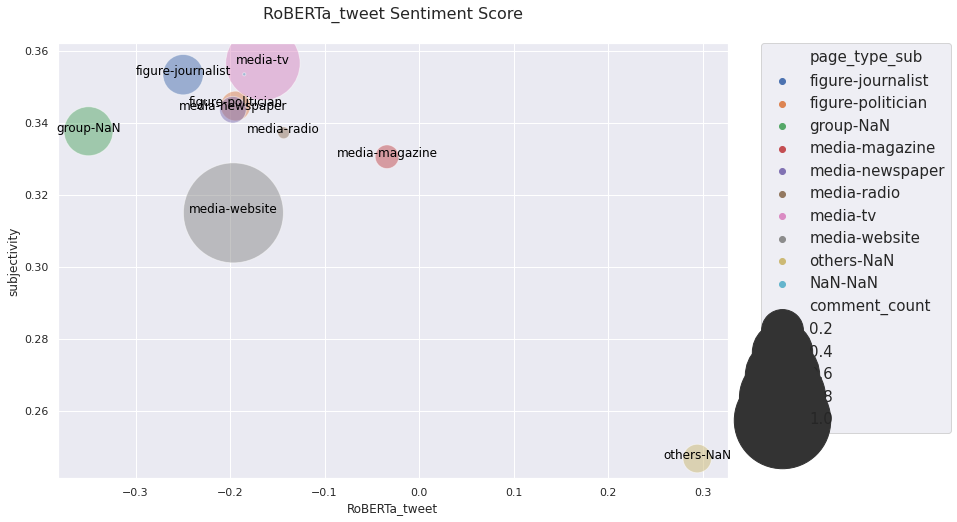

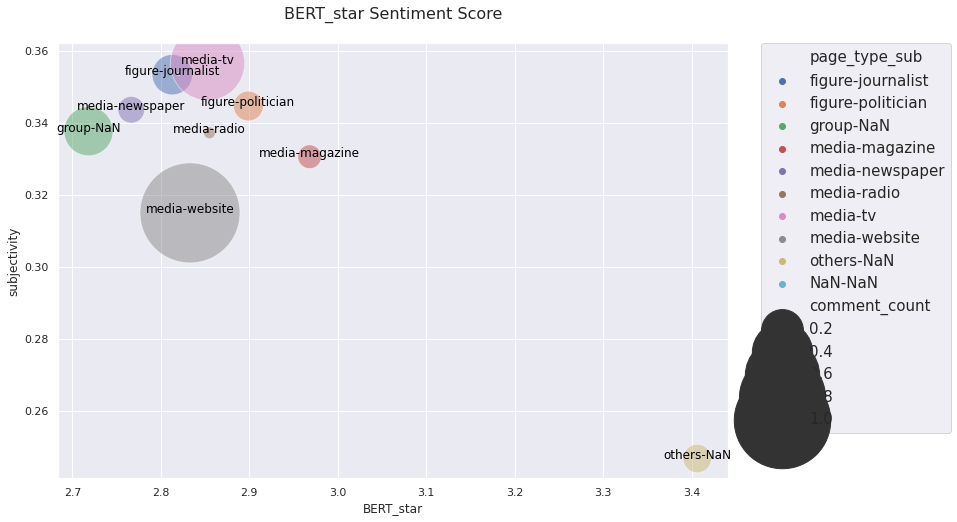

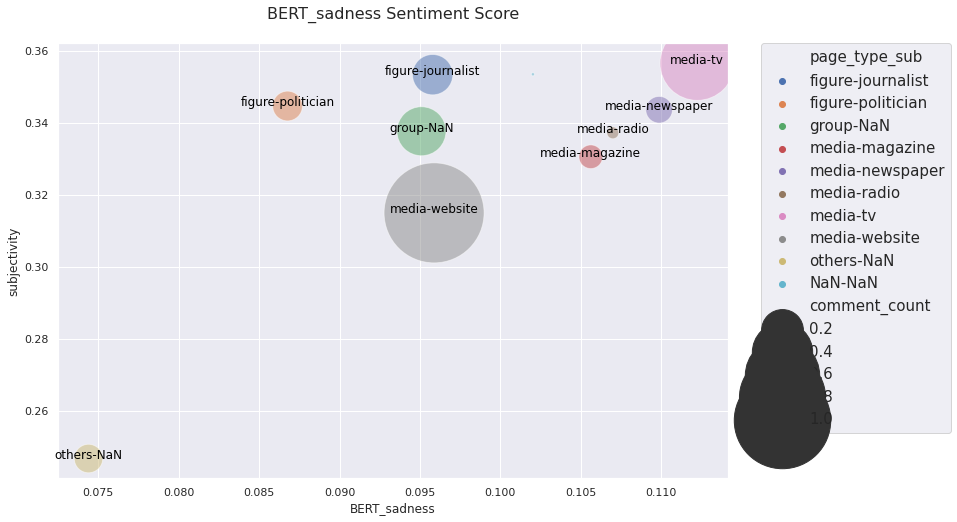

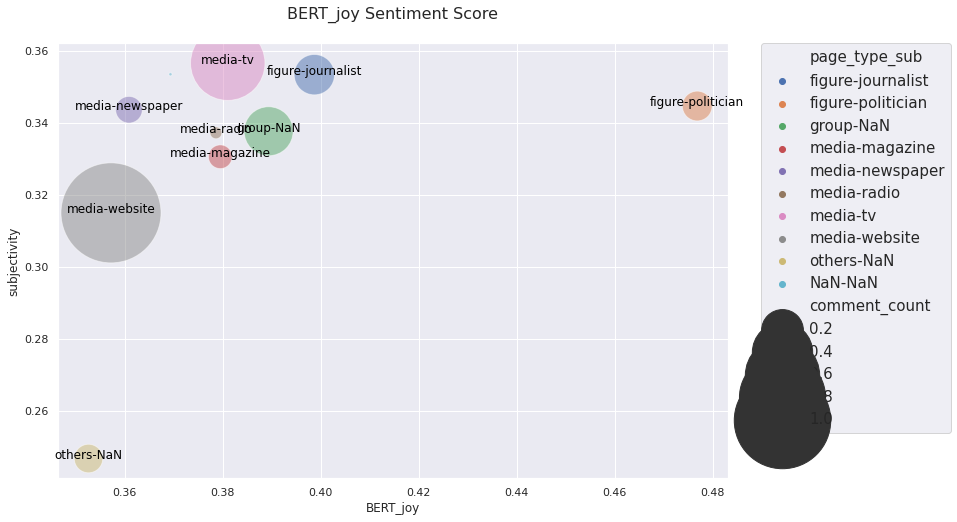

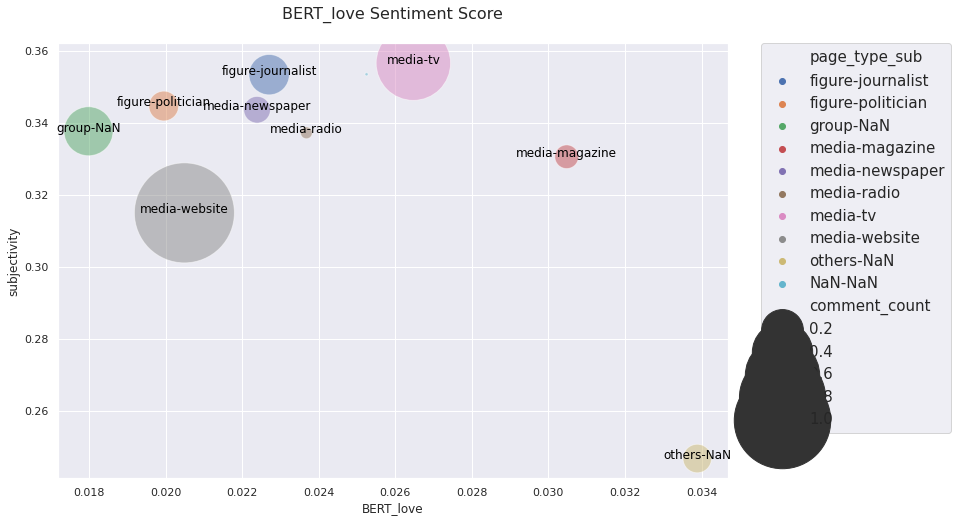

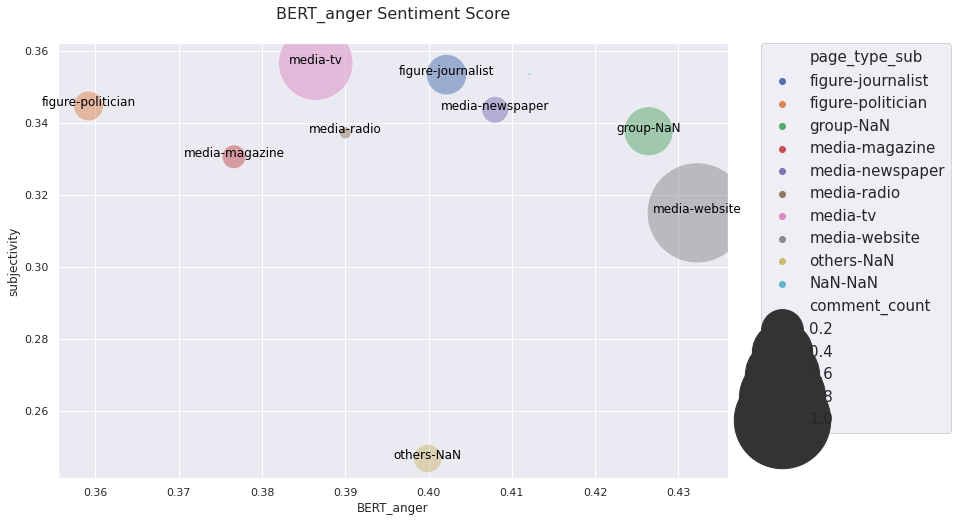

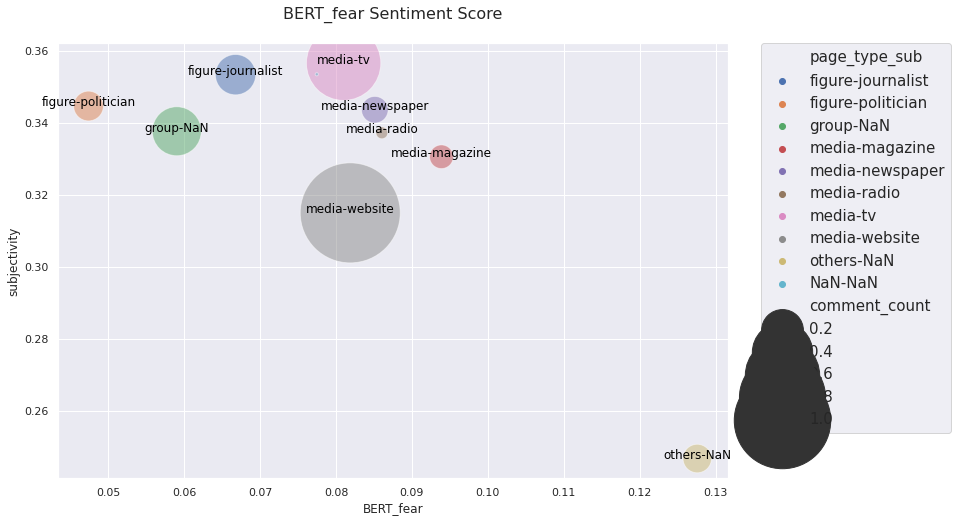

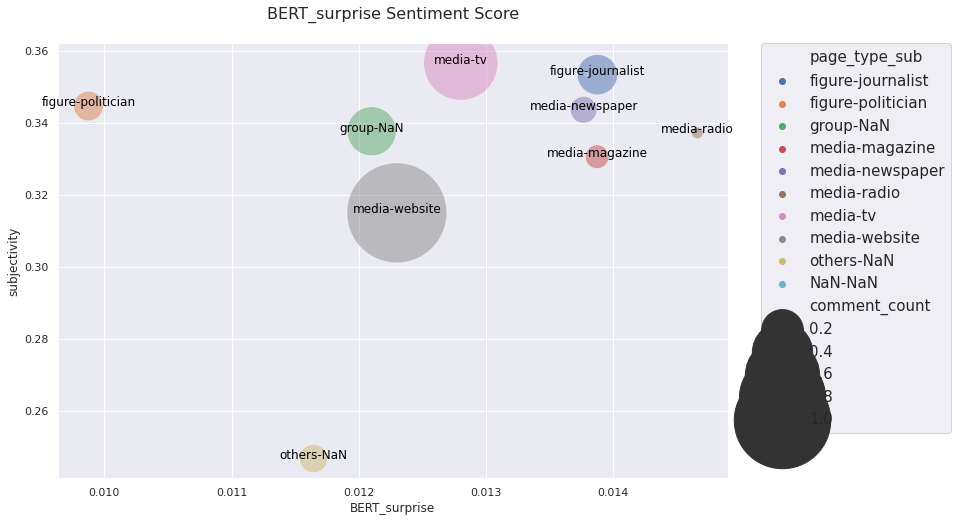

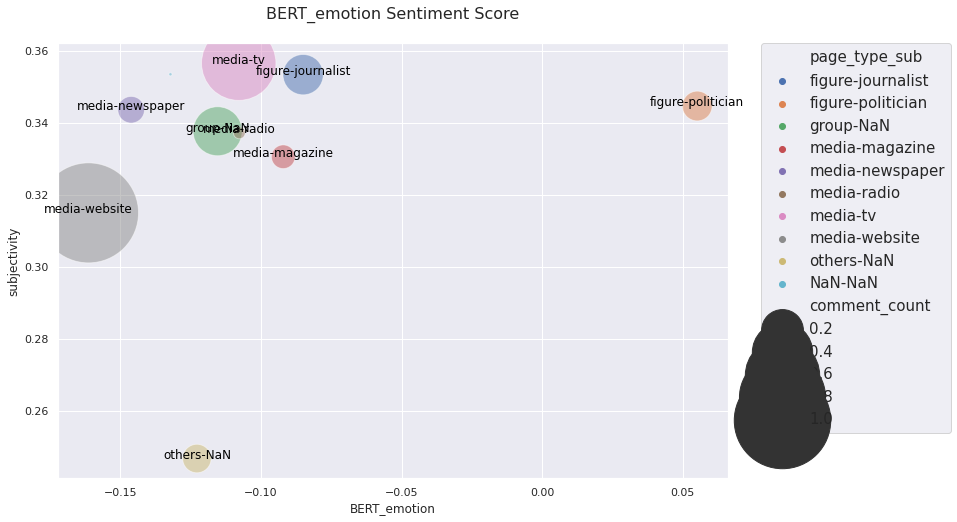

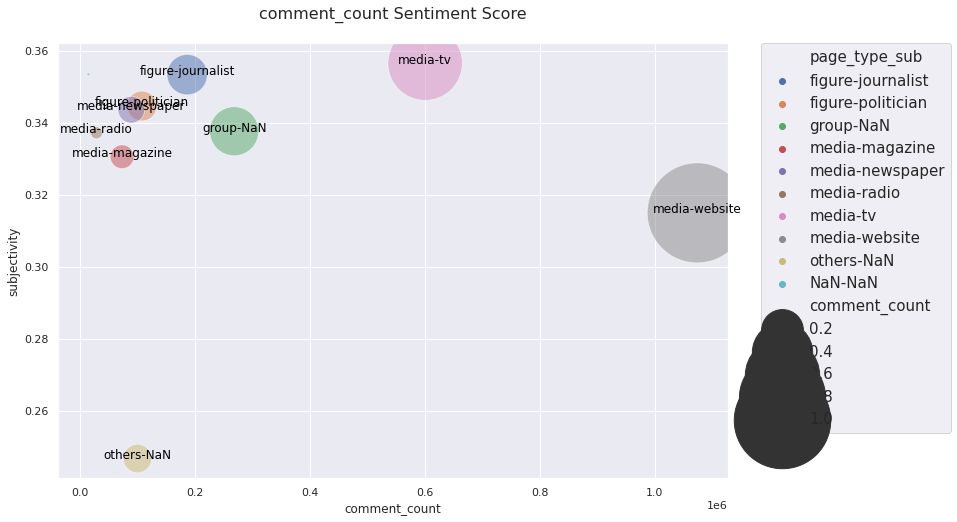

In [356]:
# Bubbleplot for BERT models
for sent_score in tuple(rename_dict.values())[:-1]:
    bubbleplot(sent_score)

#### Overall Results for reference

In [346]:
comment_joined.groupby(['type', 'type_sub'], dropna=False).agg(['mean', 'count'])

distilBERT_prob          distilBERT_score           \
                             mean    count             mean    count   
type   type_sub                                                        
figure journalist        0.965657   187109        -0.215620   187109   
       politician        0.967245   108295        -0.112248   108295   
group  NaN               0.964692   268824        -0.302028   268824   
media  magazine          0.961577    73842        -0.060921    73842   
       newspaper         0.963524    89896        -0.217606    89896   
       radio             0.962401    29370        -0.163559    29370   
       tv                0.965028   600932        -0.165066   600932   
       website           0.963685  1074095        -0.160056  1074095   
others NaN               0.947710   100615         0.246797   100615   
NaN    NaN               0.964900    15492        -0.195449    15492   

                  RoBERTa_large_prob          RoBERTa_large_score           \
                                mean    count                mean    count   
type   type_sub                                                              
figure journalist           0.992124   187109           -0.186013   187109   
       politician           0.992211   108295           -0.086838   108295   
group  NaN                  0.992523   268824           -0.272506   268824   
media  magazine             0.990874    73842            0.038564    73842   
       newspaper            0.990952    89896           -0.169150    89896   
       radio                0.990545    29370           -0.093582    29370   
       tv                   0.991665   600932           -0.117391   600932   
       website              0.991798  1074095           -0.123360  1074095   
others NaN                  0.988156   100615            0.472851   100615   
NaN    NaN                  0.991596    15492           -0.141154    15492   

                  RoBERTa_tweet_prob          BERT_star_1stProb           \
                                mean    count              mean    count   
type   type_sub                                                            
figure journalist           0.747746   187109          0.490403   187109   
       politician           0.741184   108295          0.509629   108295   
group  NaN                  0.745122   268824          0.493057   268824   
media  magazine             0.756712    73842          0.456348    73842   
       newspaper            0.745204    89896          0.465936    89896   
       radio                0.741502    29370          0.462198    29370   
       tv                   0.754960   600932          0.487781   600932   
       website              0.752930  1074095          0.469709  1074095   
others NaN                  0.755931   100615          0.400346   100615   
NaN    NaN                  0.753015    15492          0.481037    15492   

                  BERT_star_2ndProb          BERT_star_expectedScore           \
                               mean    count                    mean    count   
type   type_sub                                                                 
figure journalist          0.239254   187109                2.844669   187109   
       politician          0.230139   108295                2.924871   108295   
group  NaN                 0.235163   268824                2.753325   268824   
media  magazine            0.245186    73842                2.931363    73842   
       newspaper           0.245672    89896                2.798639    89896   
       radio               0.246910    29370                2.864161    29370   
       tv                  0.239129   600932                2.870856   600932   
       website             0.239352  1074095                2.824450  1074095   
others NaN                 0.243507   100615                3.204544   100615   
NaN    NaN                 0.240701    15492                2.836692    15492   

                  BERT_

#### And.. that's all for this project!

# Thank you for your review!